#### Imports

In [1]:
import numpy as np 
import pandas as pd 

import allensdk
import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA

from tqdm import tqdm

import torch
from torch import nn
from torchvision.transforms import Resize

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
matplotlib.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 150

/home/abalwani6/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Load data

In [3]:
cache_dir = r"Data"
bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

/home/abalwani6/.local/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [4]:
behavior_session_table = bc.get_behavior_session_table()  
ophys_session_table = bc.get_ophys_session_table()   
experiment_table = bc.get_ophys_experiment_table()

print(f"Number of behavior sessions = {len(behavior_session_table)}")
print(f"Number of ophys sessions = {len(ophys_session_table)}")
print(f"Number of ophys experiments = {len(experiment_table)}")

Number of behavior sessions = 4782
Number of ophys sessions = 703
Number of ophys experiments = 1936


In [5]:
# PC, ViP, SST lines 
pc_line_str = 'Slc17a7-IRES2-Cre' 
sst_line_str = 'Sst-IRES-Cre'
vip_line_str = 'Vip-IRES-Cre' 

In [6]:
# filtering by cell type 
pc_exp_table = experiment_table[(experiment_table.cre_line==pc_line_str)]
vip_exp_table = experiment_table[(experiment_table.cre_line==vip_line_str)]
sst_exp_table = experiment_table[(experiment_table.cre_line==sst_line_str)]

# numbers 
print(f"Number of experiments with PC neurons = {len(pc_exp_table)}")
print(f"Number of experiments with VIP neurons = {len(vip_exp_table)}")
print(f"Number of experiments with SST neurons = {len(sst_exp_table)}")

Number of experiments with PC neurons = 871
Number of experiments with VIP neurons = 663
Number of experiments with SST neurons = 402


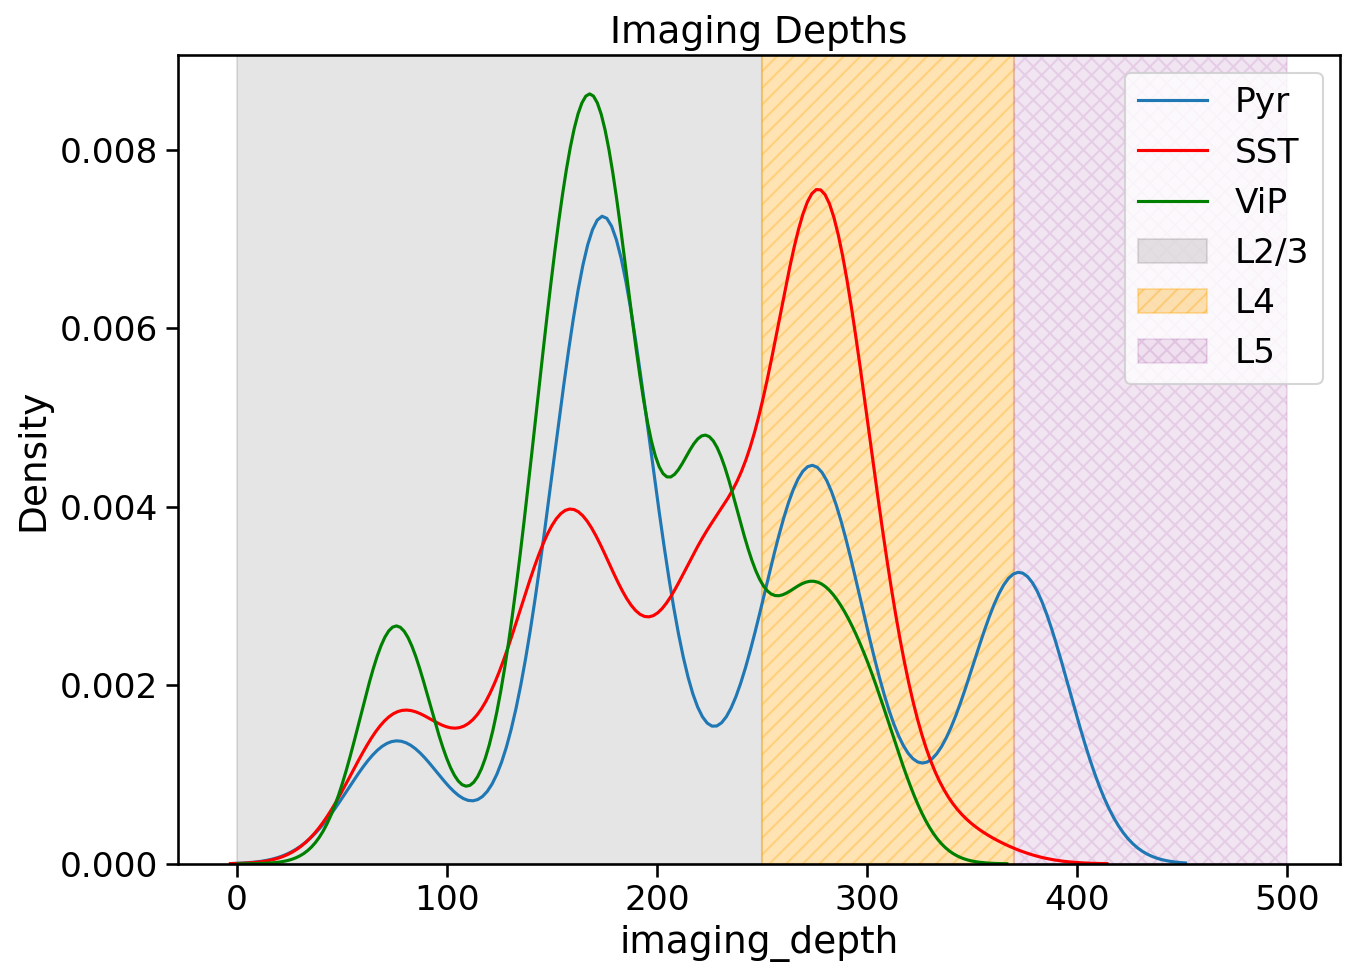

In [7]:
sns.kdeplot(data=pc_exp_table, x="imaging_depth",label='Pyr')
sns.kdeplot(data=sst_exp_table, x="imaging_depth",color='r',label='SST')
sns.kdeplot(data=vip_exp_table, x="imaging_depth",color='g',label='ViP')

## Add shaded panels
## previous numbers
# L23_start, L23_end = 125, 185  # define the range for L23
# L4_start, L4_end = 160, 210  # define the range for L4
# L5_start, L5_end = 220, 300  # define the range for L5

## new numbers
L23_start, L23_end = 0, 250 # define the range for L23
L4_start, L4_end = 250, 370  # define the range for L4
L5_start, L5_end = 370, 500  # define the range for L5


plt.axvspan(L23_start, L23_end, color='k',hatch='', alpha=0.1, label='L2/3')
plt.axvspan(L4_start, L4_end, color='orange',hatch='///', alpha=0.3, label='L4')
plt.axvspan(L5_start, L5_end, color='purple',hatch='xxx', alpha=0.1, label='L5')

plt.title('Imaging Depths')
plt.legend()

#### Filter dataset

In [8]:
# pc_exp_table.__dict__

In [9]:
## Filter by project type
filter_pyr = pc_exp_table[pc_exp_table['project_code'] == 'VisualBehaviorMultiscope']
filter_sst = sst_exp_table[sst_exp_table['project_code'] == 'VisualBehaviorMultiscope']
filter_vip = vip_exp_table[vip_exp_table['project_code'] == 'VisualBehaviorMultiscope']

## Keep only active sessions
filter_pyr = filter_pyr[filter_pyr['passive'] == False]
filter_sst = filter_sst[filter_sst['passive'] == False]
filter_vip = filter_vip[filter_vip['passive'] == False]

## Filter to keep only FAMILIAR sessions
filter_pyr = filter_pyr[filter_pyr['experience_level'] == 'Familiar']
filter_sst = filter_sst[filter_sst['experience_level'] == 'Familiar']
filter_vip = filter_vip[filter_vip['experience_level'] == 'Familiar']

In [10]:
# numbers 
print(f"Number of experiments with PYR neurons = {len(filter_pyr)}")
print(f"Number of experiments with SST neurons = {len(filter_sst)}")
print(f"Number of experiments with VIP neurons = {len(filter_vip)}")

Number of experiments with PYR neurons = 124
Number of experiments with SST neurons = 77
Number of experiments with VIP neurons = 117


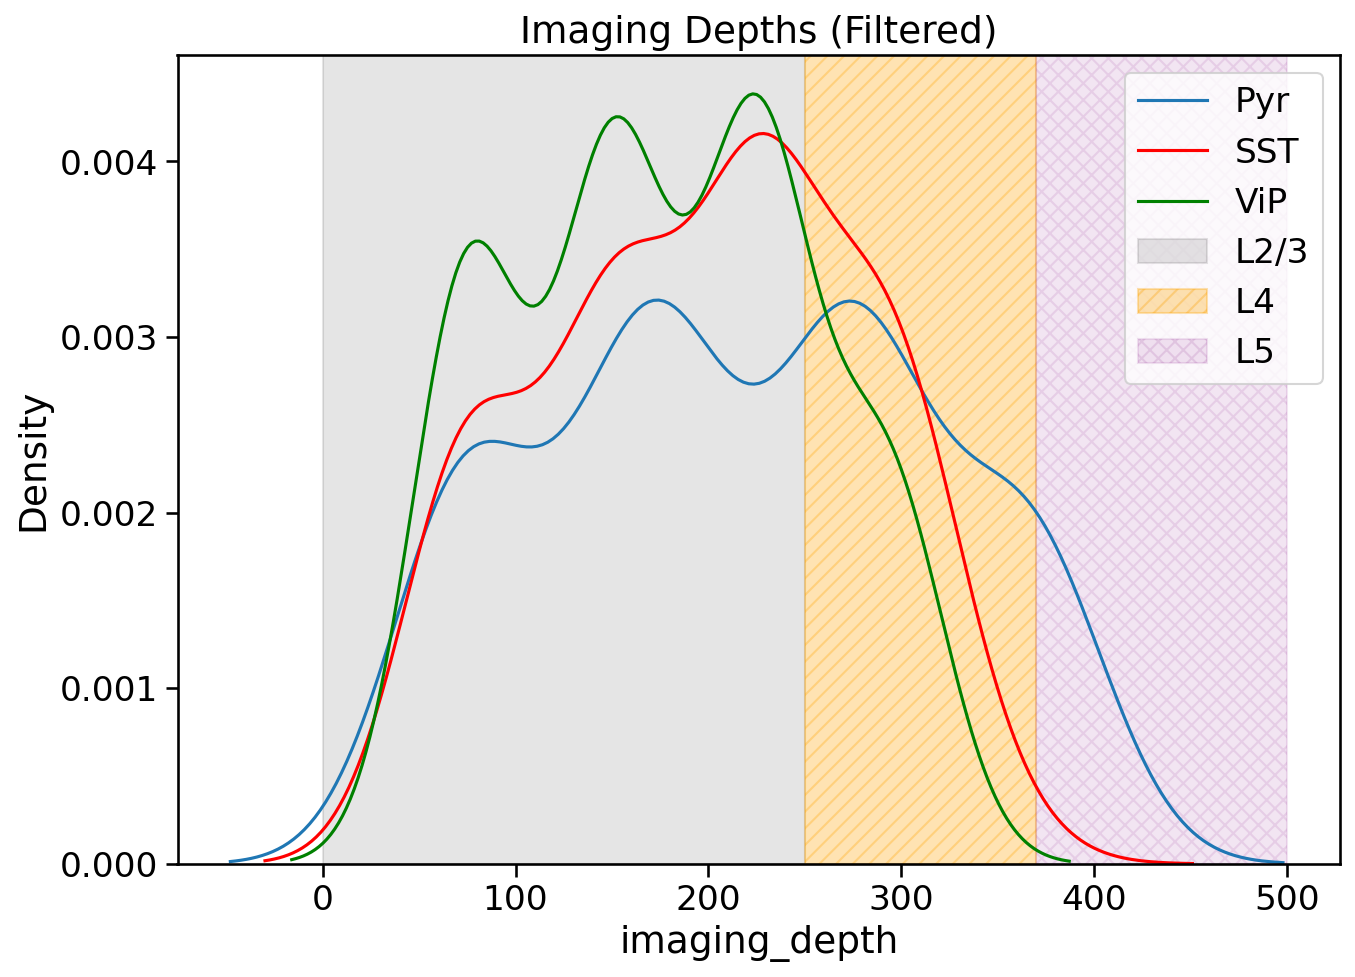

In [11]:
sns.kdeplot(data=filter_pyr, x="imaging_depth",label='Pyr')
sns.kdeplot(data=filter_sst, x="imaging_depth",color='r',label='SST')
sns.kdeplot(data=filter_vip, x="imaging_depth",color='g',label='ViP')

## Add shaded panels
# L23_start, L23_end = 125, 250 # define the range for L23
# L4_start, L4_end = 250, 370  # define the range for L4
# L5_start, L5_end = 310, 500  # define the range for L5

## new numbers
L23_start, L23_end = 0, 250 # define the range for L23
L4_start, L4_end = 250, 370  # define the range for L4
L5_start, L5_end = 370, 500  # define the range for L5

plt.axvspan(L23_start, L23_end, color='k',hatch='', alpha=0.1, label='L2/3')
plt.axvspan(L4_start, L4_end, color='orange',hatch='///', alpha=0.3, label='L4')
plt.axvspan(L5_start, L5_end, color='purple',hatch='xxx', alpha=0.1, label='L5')

plt.title('Imaging Depths (Filtered)')
plt.legend()

#### Split into individual cell types

In [12]:
pyr_visp = filter_pyr[filter_pyr.targeted_structure=='VISp']
sst_visp = filter_sst[filter_sst.targeted_structure=='VISp']
vip_visp = filter_vip[filter_vip.targeted_structure=='VISp']

pyr_visl = filter_pyr[filter_pyr.targeted_structure=='VISl']
sst_visl = filter_sst[filter_sst.targeted_structure=='VISl']
vip_visl = filter_vip[filter_vip.targeted_structure=='VISl']

#### Depthwise splitting (individual cell types)

In [13]:
depths_pyr_visp = pyr_visp.imaging_depth
depths_sst_visp = sst_visp.imaging_depth
depths_vip_visp = vip_visp.imaging_depth

depths_pyr_visl = pyr_visl.imaging_depth
depths_sst_visl = sst_visl.imaging_depth
depths_vip_visl = vip_visl.imaging_depth

In [14]:
print('Pyr (VISp):',np.unique(depths_pyr_visp))
print('SST (VISp):',np.unique(depths_sst_visp))
print('ViP (VISp):',np.unique(depths_vip_visp))

Pyr (VISp): [ 67  69  73  75  77  79 150 161 165 169 171 175 181 183 225 229 263 267
 269 270 273 275 298 300 340 359 361 365 371 373 375 381 383]
SST (VISp): [ 75  81 144 145 150 154 175 221 225 230 275 300 320 321 350]
ViP (VISp): [ 71  73  75  77  79  81 150 152 154 156 158 217 219 221 225 270 278 298
 300]


In [15]:
## Use to check number of experiments beyond a certain depth

# print(len(filter_pyr[filter_pyr['imaging_depth']>370]))
# print(len(filter_sst[filter_sst['imaging_depth']>320]))
# print(len(filter_vip[filter_vip['imaging_depth']>300]))

In [16]:
pyr_visp_L23_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L23_start) & (pyr_visp['imaging_depth'] <= L23_end)]['ophys_session_id']
sst_visp_L23_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= L23_start) & (sst_visp['imaging_depth'] <= L23_end)]['ophys_session_id']
vip_visp_L23_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= L23_start) & (vip_visp['imaging_depth'] <= L23_end)]['ophys_session_id']

pyr_visp_L4_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L4_start) & (pyr_visp['imaging_depth'] <= L4_end)]['ophys_session_id']
sst_visp_L4_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= L4_start) & (sst_visp['imaging_depth'] <= L4_end)]['ophys_session_id']
vip_visp_L4_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= L4_start) & (vip_visp['imaging_depth'] <= L4_end)]['ophys_session_id']

pyr_visp_L5_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L5_start) & (pyr_visp['imaging_depth'] <= L5_end)]['ophys_session_id']
sst_visp_L5_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= 295) & (sst_visp['imaging_depth'] <= L5_end)]['ophys_session_id']
vip_visp_L5_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= 295) & (vip_visp['imaging_depth'] <= L5_end)]['ophys_session_id']

In [17]:
print(len(pyr_visp_L23_ophys_ids))
print(len(sst_visp_L23_ophys_ids))
print(len(vip_visp_L23_ophys_ids))

print(len(pyr_visp_L4_ophys_ids))
print(len(sst_visp_L4_ophys_ids))
print(len(vip_visp_L4_ophys_ids))

print(len(pyr_visp_L5_ophys_ids))
print(len(sst_visp_L5_ophys_ids))
print(len(vip_visp_L5_ophys_ids))

35
37
48
23
9
4
8
7
2


In [18]:
print('Pyr (VISl):',np.unique(depths_pyr_visl))
print('SST (VISl):',np.unique(depths_sst_visl))
print('ViP (VISl):',np.unique(depths_vip_visl))

Pyr (VISl): [ 71  75  77  79  85 150 167 169 171 175 181 221 225 259 263 270 271 275
 277 283 300 345 355 359 363 365 373 375 379]
SST (VISl): [ 71  75 150 175 213 225 228 230 235 275 283 284 285 290 300]
ViP (VISl): [ 71  75  79  93 144 148 150 162 174 211 219 225 274 276 282 286 292 294
 300]


In [19]:
pyr_visl_L23_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L23_start) & (pyr_visl['imaging_depth'] <= L23_end)]['ophys_session_id']
sst_visl_L23_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= L23_start) & (sst_visl['imaging_depth'] <= L23_end)]['ophys_session_id']
vip_visl_L23_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= L23_start) & (vip_visl['imaging_depth'] <= L23_end)]['ophys_session_id']

pyr_visl_L4_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L4_start) & (pyr_visl['imaging_depth'] <= L4_end)]['ophys_session_id']
sst_visl_L4_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= L4_start) & (sst_visl['imaging_depth'] <= L4_end)]['ophys_session_id']
vip_visl_L4_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= L4_start) & (vip_visl['imaging_depth'] <= L4_end)]['ophys_session_id']

pyr_visl_L5_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L5_start) & (pyr_visl['imaging_depth'] <= L5_end)]['ophys_session_id']
sst_visl_L5_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= 295) & (sst_visl['imaging_depth'] <= L5_end)]['ophys_session_id']
vip_visl_L5_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= 295) & (vip_visl['imaging_depth'] <= L5_end)]['ophys_session_id']

In [20]:
print(len(pyr_visl_L23_ophys_ids))
print(len(sst_visl_L23_ophys_ids))
print(len(vip_visl_L23_ophys_ids))

print(len(pyr_visl_L4_ophys_ids))
print(len(sst_visl_L4_ophys_ids))
print(len(vip_visl_L4_ophys_ids))

print(len(pyr_visl_L5_ophys_ids))
print(len(sst_visl_L5_ophys_ids))
print(len(vip_visl_L5_ophys_ids))

32
20
49
23
11
16
3
5
8


#### Download experiments and produce average response

In [21]:
def generate_trial_avg_response_familiar_change(ophys_ids, default_length=16):
    
    dff_avg_stacked_full_flag = False
    for ii in range(len(ophys_ids)):
        try:
            experiment = bc.get_behavior_ophys_experiment(ophys_ids.index[ii])
        except OSError:
            print('Skipping an experiment')
            continue
            
        timestamps = experiment.ophys_timestamps
        stim_table = experiment.stimulus_presentations
        trial_table = experiment.trials.merge(experiment._trials._trials.fillna(method='ffill'), left_index=True, right_index=True)
        trial_table = trial_table[trial_table.is_change_x==True] ## only samples with changes in image ID
        
        dff_array = np.vstack(experiment.dff_traces['dff'].values)

        # print(ii)
        # print(len(trial_table))
        # print('-----------------')
        
        initial_array_flag = False
        for jj in range(len(trial_table)):
            sample_trial = trial_table.iloc[jj]
            
            start_time = sample_trial['start_time_x']
            stop_time = sample_trial['stop_time_x']

            # Filter stimulus presentations based on start and stop times
            filtered_stimuli = stim_table[(stim_table['start_time'] >= start_time) & (stim_table['start_time'] <= stop_time)]
        
            # Extract image names 
            images = [image_name for image_name in filtered_stimuli['image_name']]

            #### CHECK FOR DELTA DEFINITION!!!
            if len(np.where(images == 'omitted')[0]) == 0:
                change_time = sample_trial['change_time_x']
    
                sub_start = change_time - 0.5 - 0.25
                sub_end = change_time + 0.25 + 0.5
                
                trial_mask = (timestamps >= start_time) & (timestamps <= stop_time)
                
                # Filter dF/F traces based on the trial mask
                dff_trial = dff_array[:, trial_mask]

                delta = np.round((stop_time - start_time)/np.sum(trial_mask),3)
                
                sub_start_frame = int((sub_start - start_time)/delta)
                sub_end_frame = int((sub_end - start_time)/delta)

                if (sub_end_frame-sub_start_frame)!=default_length:
                   dff_avg = np.mean(dff_trial,0)[sub_start_frame:sub_start_frame+default_length]
                else:
                    dff_avg = np.mean(dff_trial,0)[sub_start_frame:sub_end_frame]

                if initial_array_flag == False:
                    dff_avg_stacked = dff_avg
                    initial_array_flag = True
                else:
                    dff_avg_stacked = np.vstack((dff_avg_stacked, dff_avg))
                
        if dff_avg_stacked_full_flag == False:
            dff_avg_stacked_full = dff_avg_stacked
            dff_avg_stacked_full_flag = True
        else:
            dff_avg_stacked_full = np.vstack((dff_avg_stacked_full,dff_avg_stacked))
                
    return dff_avg_stacked_full

In [22]:
dff_pyr_visp_L23 = generate_trial_avg_response_familiar_change(pyr_visp_L23_ophys_ids)
np.save('dff_pyr_visp_L23_familiar_change.npy',dff_pyr_visp_L23)
print('Pyr - L23')
dff_pyr_visp_L4 = generate_trial_avg_response_familiar_change(pyr_visp_L4_ophys_ids)
np.save('dff_pyr_visp_L4_familiar_change.npy',dff_pyr_visp_L4)
print('Pyr - L4')
dff_pyr_visp_L5 = generate_trial_avg_response_familiar_change(pyr_visp_L5_ophys_ids)
np.save('dff_pyr_visp_L5_familiar_change.npy',dff_pyr_visp_L5)
print('Pyr - L5')

dff_sst_visp_L23 = generate_trial_avg_response_familiar_change(sst_visp_L23_ophys_ids)
np.save('dff_sst_visp_L23_familiar_change.npy',dff_sst_visp_L23)
print('SST - L23')
dff_sst_visp_L4 = generate_trial_avg_response_familiar_change(sst_visp_L4_ophys_ids)
np.save('dff_sst_visp_L4_familiar_change.npy',dff_sst_visp_L4)
print('SST - L23')
dff_sst_visp_L5 = generate_trial_avg_response_familiar_change(sst_visp_L5_ophys_ids)
np.save('dff_sst_visp_L5_familiar_change.npy',dff_sst_visp_L5)
print('SST - L23')

dff_vip_visp_L23 = generate_trial_avg_response_familiar_change(vip_visp_L23_ophys_ids)
np.save('dff_vip_visp_L23_familiar_change.npy',dff_vip_visp_L23)
print('VIP - L23')
dff_vip_visp_L4 = generate_trial_avg_response_familiar_change(vip_visp_L4_ophys_ids)
np.save('dff_vip_visp_L4_familiar_change.npy',dff_vip_visp_L4)
print('VIP - L4')
dff_vip_visp_L5 = generate_trial_avg_response_familiar_change(vip_visp_L5_ophys_ids)
np.save('dff_vip_visp_L5_familiar_change.npy',dff_vip_visp_L5)
print('VIP - L5')

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

Skipping an experiment


behavior_ophys_experiment_1084326129.nwb: 100%|█| 369M/369M [00:12<00:00, 30.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1084326126.nwb: 100%|█| 644M/644M [00:22<00:00, 28.6MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Pyr - L23


behavior_ophys_experiment_986518878.nwb: 100%|█| 482M/482M [00:17<00:00, 27.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518885.nwb: 100%|█| 413M/413M [00:13<00:00, 30.6MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213059.nwb: 100%|█| 432M/432M [00:14<00:00, 29.9MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213061.nwb: 100%|█| 345M/345M [00:11<00:00, 30.7MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L4


behavior_ophys_experiment_992620390.nwb: 100%|█| 245M/245M [00:09<00:00, 26.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_993369858.nwb: 100%|█| 263M/263M [00:09<00:00, 26.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_971813756.nwb: 100%|█| 399M/399M [00:28<00:00, 14.2MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_974433388.nwb: 100%|█| 419M/419M [00:15<00:00, 27.1MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L5


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980473.nwb: 100%|█| 248M/248M [00:08<00:00, 27.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980475.nwb: 100%|█| 248M/248M [00:09<00:00, 25.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527464.nwb: 100%|█| 246M/246M [00:09<00:00, 25.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.

SST - L23


behavior_ophys_experiment_1080945465.nwb: 100%|█| 239M/239M [00:08<00:00, 27.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1076531978.nwb: 100%|█| 245M/245M [00:08<00:00, 27.9MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1076808562.nwb: 100%|█| 250M/250M [00:09<00:00, 27.6MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_975608390.nwb: 100%|█| 241M/241M [00:08<00:00, 27.5MMB
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

SST - L23


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1048483608.nwb: 100%|█| 261M/261M [00:09<00:00, 26.9MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485645.nwb: 100%|█| 245M/245M [00:08<00:00, 28.2MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485649.nwb: 100%|█| 258M/258M [00:09<00:00, 27.4MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.

VIP - L23


behavior_ophys_experiment_881001216.nwb: 100%|█| 233M/233M [00:08<00:00, 28.2MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_882551937.nwb: 100%|█| 243M/243M [00:08<00:00, 29.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_872499150.nwb: 100%|█| 261M/261M [00:09<00:00, 27.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_873970525.nwb: 100%|█| 250M/250M [00:08<00:00, 28.8MMB
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


VIP - L5


In [23]:
dff_pyr_visl_L23 = generate_trial_avg_response_familiar_change(pyr_visl_L23_ophys_ids)
np.save('dff_pyr_visl_L23_familiar_change.npy',dff_pyr_visl_L23)
print('Pyr - L23')
dff_pyr_visl_L4 = generate_trial_avg_response_familiar_change(pyr_visl_L4_ophys_ids)
np.save('dff_pyr_visl_L4_familiar_change.npy',dff_pyr_visl_L4)
print('Pyr - L4')
dff_pyr_visl_L5 = generate_trial_avg_response_familiar_change(pyr_visl_L5_ophys_ids)
np.save('dff_pyr_visl_L5_familiar_change.npy',dff_pyr_visl_L5)
print('Pyr - L5')

dff_sst_visl_L23 = generate_trial_avg_response_familiar_change(sst_visl_L23_ophys_ids)
np.save('dff_sst_visl_L23_familiar_change.npy',dff_sst_visl_L23)
print('SST - L23')
dff_sst_visl_L4 = generate_trial_avg_response_familiar_change(sst_visl_L4_ophys_ids)
np.save('dff_sst_visl_L4_familiar_change.npy',dff_sst_visl_L4)
print('SST - L4')
dff_sst_visl_L5 = generate_trial_avg_response_familiar_change(sst_visl_L5_ophys_ids)
np.save('dff_sst_visl_L5_familiar_change.npy',dff_sst_visl_L5)
print('SST - L5')

dff_vip_visl_L23 = generate_trial_avg_response_familiar_change(vip_visl_L23_ophys_ids)
np.save('dff_vip_visl_L23_familiar_change.npy',dff_vip_visl_L23)
print('VIP - L23')
dff_vip_visl_L4 = generate_trial_avg_response_familiar_change(vip_visl_L4_ophys_ids)
np.save('dff_vip_visl_L4_familiar_change.npy',dff_vip_visl_L4)
print('VIP - L4')
dff_vip_visl_L5 = generate_trial_avg_response_familiar_change(vip_visl_L5_ophys_ids)
np.save('dff_vip_visl_L5_familiar_change.npy',dff_vip_visl_L5)
print('VIP - L5')

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

Skipping an experiment


behavior_ophys_experiment_882551964.nwb: 100%|█| 339M/339M [00:11<00:00, 28.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_882551968.nwb: 100%|█| 310M/310M [00:10<00:00, 28.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_886003531.nwb: 100%|█| 288M/288M [00:10<00:00, 28.6MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.

Pyr - L23


behavior_ophys_experiment_986518889.nwb: 100%|█| 381M/381M [00:12<00:00, 30.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518893.nwb: 100%|█| 268M/268M [00:09<00:00, 29.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213063.nwb: 100%|█| 396M/396M [00:14<00:00, 27.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213065.nwb: 100%|█| 259M/259M [00:09<00:00, 28.2MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Pyr - L5


behavior_ophys_experiment_951980479.nwb: 100%|█| 266M/266M [00:08<00:00, 30.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980481.nwb: 100%|█| 252M/252M [00:08<00:00, 28.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980484.nwb: 100%|█| 237M/237M [00:07<00:00, 30.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527479.nwb: 100%|█| 254M/254M [00:09<00:00, 27.7MMB
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


behavior_ophys_experiment_951980486.nwb: 100%|█| 244M/244M [00:09<00:00, 26.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527488.nwb: 100%|█| 236M/236M [00:09<00:00, 24.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958741234.nwb: 100%|█| 234M/234M [00:09<00:00, 23.9MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1080945471.nwb: 100%|█| 236M/236M [00:09<00:00, 25.1MM
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

SST - L23


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

VIP - L23


behavior_ophys_experiment_1048483616.nwb: 100%|█| 247M/247M [00:11<00:00, 21.8MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485657.nwb: 100%|█| 236M/236M [00:09<00:00, 24.2MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_930996080.nwb: 100%|█| 237M/237M [00:10<00:00, 23.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_938002083.nwb: 100%|█| 234M/234M [00:10<00:00, 22.2MMB
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

VIP - L5


In [27]:
print(dff_pyr_visp_L23.shape)
print(dff_pyr_visp_L4.shape)
print(dff_pyr_visp_L5.shape)

print(dff_sst_visp_L23.shape)
print(dff_sst_visp_L4.shape)
print(dff_sst_visp_L5.shape)

print(dff_vip_visp_L23.shape)
print(dff_vip_visp_L4.shape)
print(dff_vip_visp_L5.shape)

(9015, 16)
(6182, 16)
(1990, 16)
(8806, 16)
(2326, 16)
(1725, 16)
(11453, 16)
(990, 16)
(351, 16)


In [26]:
print(dff_pyr_visl_L23.shape)
print(dff_pyr_visl_L4.shape)
print(dff_pyr_visl_L5.shape)

print(dff_sst_visl_L23.shape)
print(dff_sst_visl_L4.shape)
print(dff_sst_visl_L5.shape)

print(dff_vip_visl_L23.shape)
print(dff_vip_visl_L4.shape)
print(dff_vip_visl_L5.shape)

(8060, 16)
(6080, 16)
(888, 16)
(4668, 16)
(2710, 16)
(1115, 16)
(12379, 16)
(3763, 16)
(2304, 16)


#### Plots

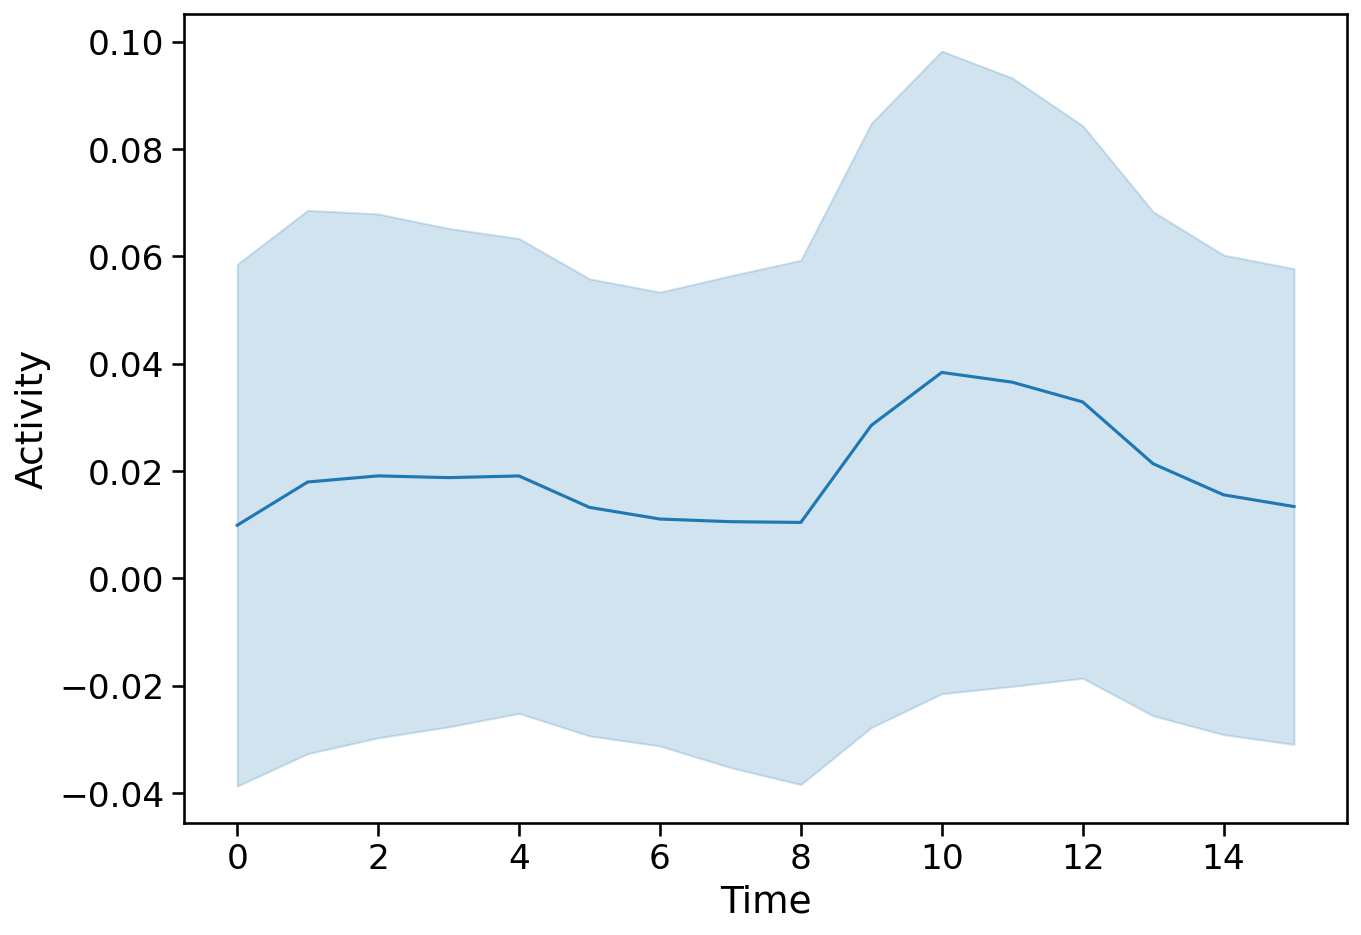

In [34]:
df = pd.DataFrame(dff_pyr_visl_L23)
# Melt DataFrame to long format
df_long = df.melt(var_name='Time', value_name='Activity')
# Create the Seaborn line plot with shaded area
sns.lineplot(data=df_long, x='Time', y='Activity', errorbar='sd')
# Show the plot
plt.show()

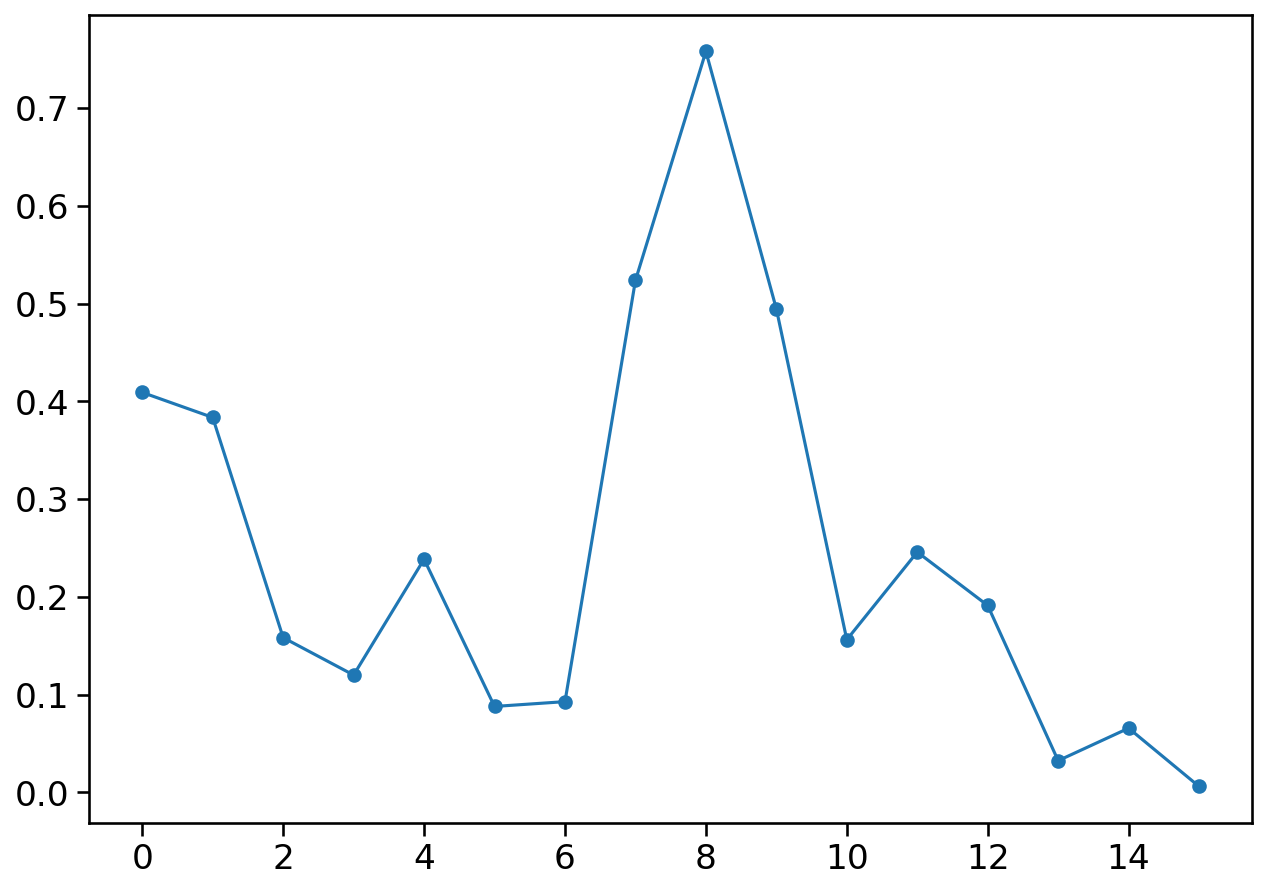

In [59]:
plt.plot(dff_vip_visl_L23[600],'o-')

In [872]:
len(pyr_visp_L23_ophys_ids)

35

In [875]:
ii = 9
exp = bc.get_behavior_ophys_experiment(pyr_visl_L23_ophys_ids.index[ii])

tt = exp.trials.merge(exp._trials._trials.fillna(method='ffill'), left_index=True, right_index=True)
tt = tt[tt.is_change_x==True] ## only samples with changes in image ID

print(len(tt))

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


286


In [807]:
initial_array = np.empty((0,) + (sub_end_frame - sub_start_frame,))

In [810]:
stacked_array = np.vstack((initial_array, dff_avg[sub_start_frame:sub_end_frame]))

In [812]:
stacked_array.shape

(1, 16)

In [745]:
# dataset.__dict__

In [808]:
initial_array

array([], shape=(0, 16), dtype=float64)

In [744]:
# plt.plot(np.mean(dff_array,0))

In [861]:
dataset = bc.get_behavior_ophys_experiment(pyr_visl_L23_ophys_ids.index[4])
# dataset.stimulus_presentations = dataset.stimulus_presentations[dataset.stimulus_presentations['omitted']==False]

# Extract dF/F traces from the dataset
dff_array = np.vstack(dataset.dff_traces['dff'].values)
    
# Create a boolean mask for timestamps within the trial's time range
trial_table = dataset.trials.merge(dataset._trials._trials.fillna(method='ffill'), left_index=True, right_index=True)
trial_table = trial_table[trial_table.is_change_x==True]
trial = trial_table.iloc[152]
trial_mask = (dataset.ophys_timestamps >= trial['start_time_x']) &\
(dataset.ophys_timestamps <= trial['stop_time_x'])

# Filter dF/F traces based on the trial mask
dff_trial = dff_array[:, trial_mask]
dff_avg = np.mean(dff_trial,0)

behavior_ophys_experiment_881003493.nwb: 100%|█| 420M/420M [00:29<00:00, 14.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [862]:
np.sum(trial_mask)

103

In [863]:
dff_avg.shape

(103,)

In [864]:
start_time = trial.start_time_x
stop_time = trial.stop_time_x
change_time = trial.change_time_x

delta = np.round((stop_time - start_time)/np.sum(trial_mask),3)
delta ## should be approx 0.093

0.093

In [865]:
sub_start = change_time - 0.5 - 0.25
sub_end = change_time + 0.25 + 0.5
n_sub = int((sub_end-sub_start)/delta)

sub_start_frame = int((sub_start - start_time)/delta)
sub_end_frame = int((sub_end - start_time)/delta)

16


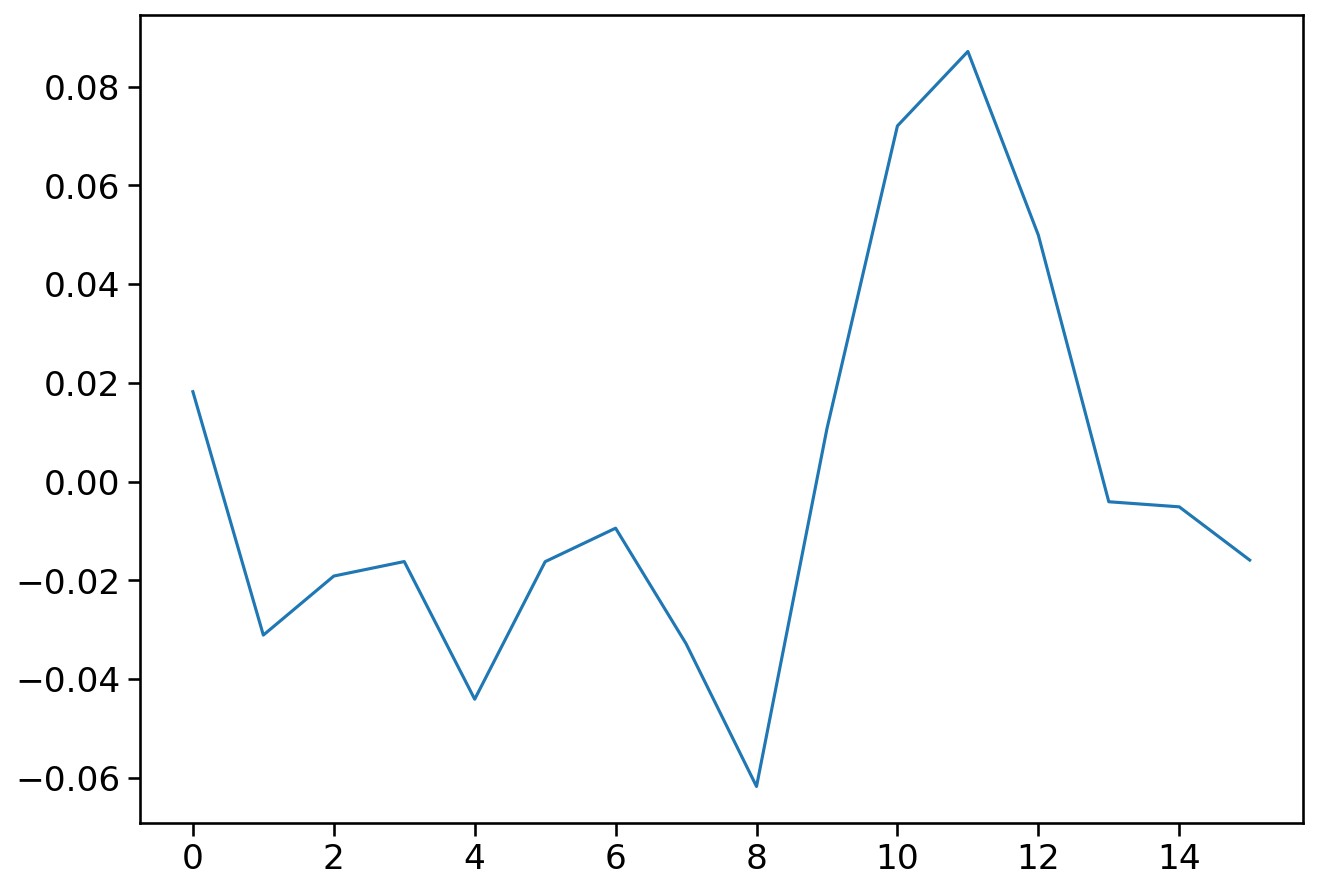

In [866]:
print(sub_end_frame-sub_start_frame)
plt.plot(dff_avg[sub_start_frame:sub_end_frame])

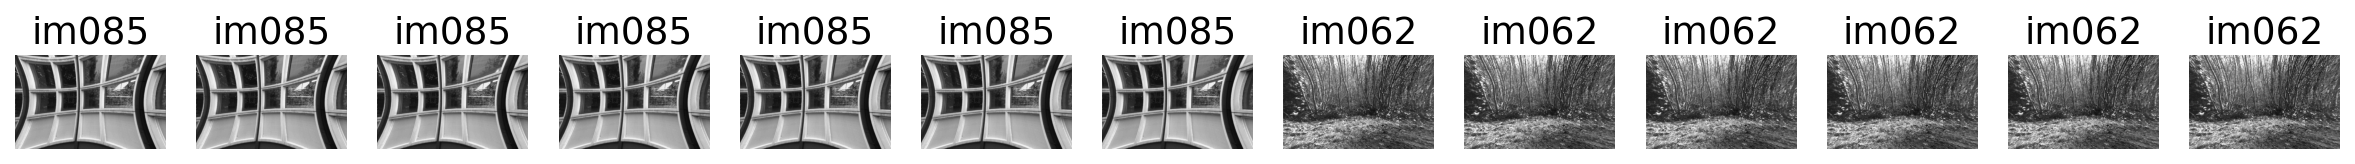

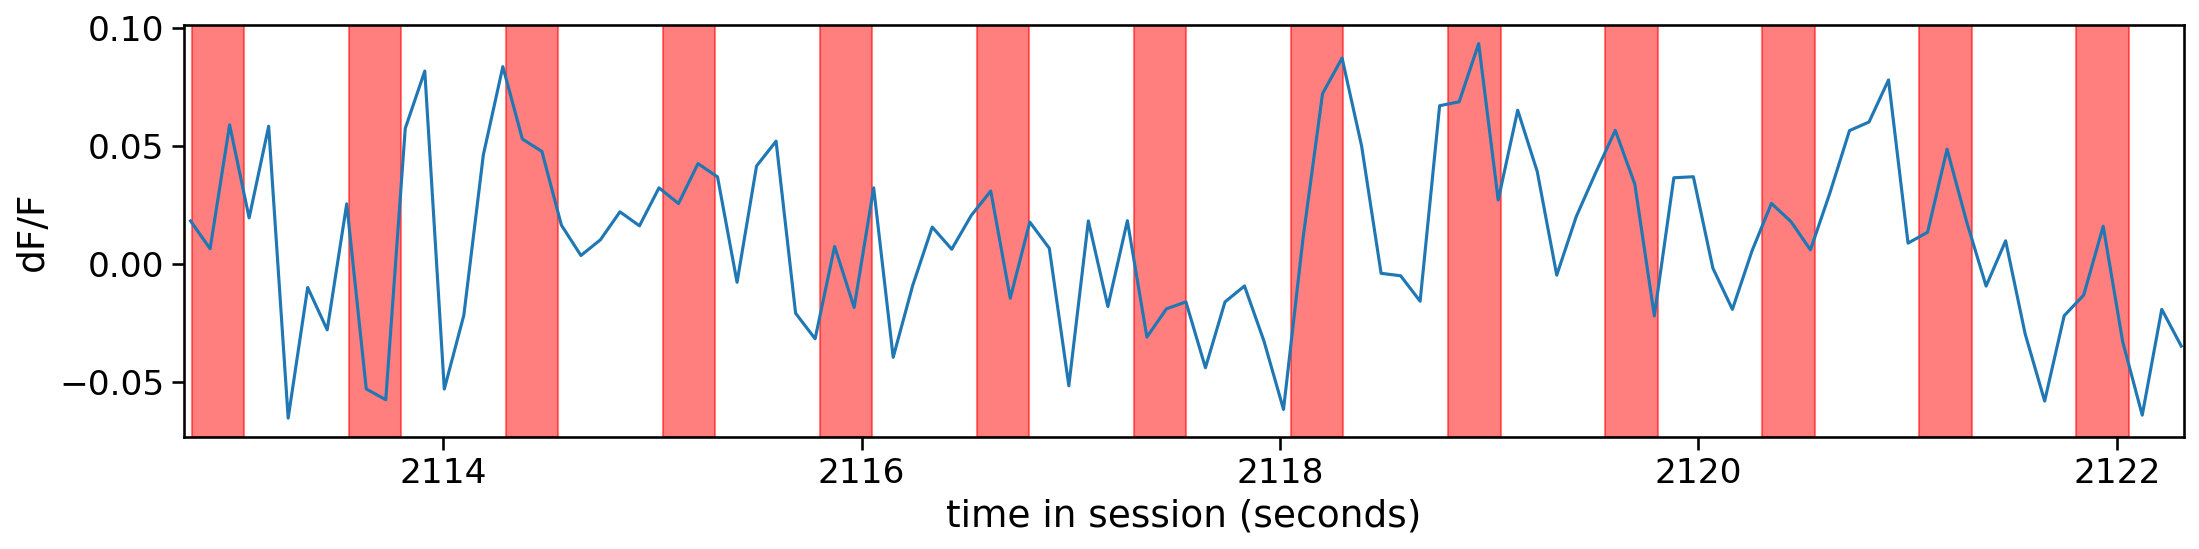

In [867]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, trial)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, trial, cell_avg=True)

In [793]:
n_sub

15

In [794]:
sub_start_frame

24

In [795]:
sub_end_frame

40

In [737]:
def resize_array(input_array, new_size):
    input_array = np.array(input_array)
    original_size = len(input_array)
    
    if original_size == new_size:
        return input_array
    
    # Generate new indices for the resized array
    new_indices = np.linspace(0, original_size - 1, new_size)
    
    # Interpolate values at new indices
    resized_array = np.interp(new_indices, np.arange(original_size), input_array)
    
    return resized_array

In [738]:
# # Example usage
# input_array = [1, 2.4, 1.3, 4.8, 3.5]
# new_size = 10
# resized_array = resize_array(input_array, new_size)
# print(resized_array)

In [739]:
# plt.plot(input_array)

In [740]:
# plt.plot(resized_array)

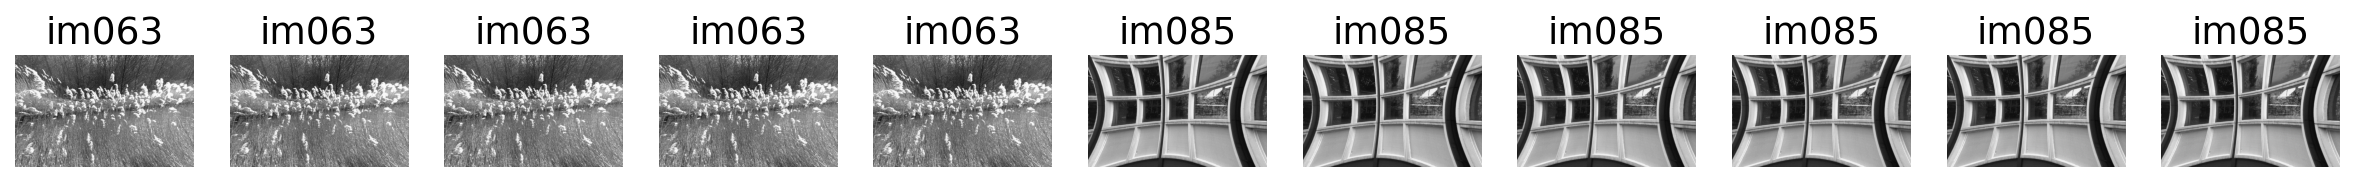

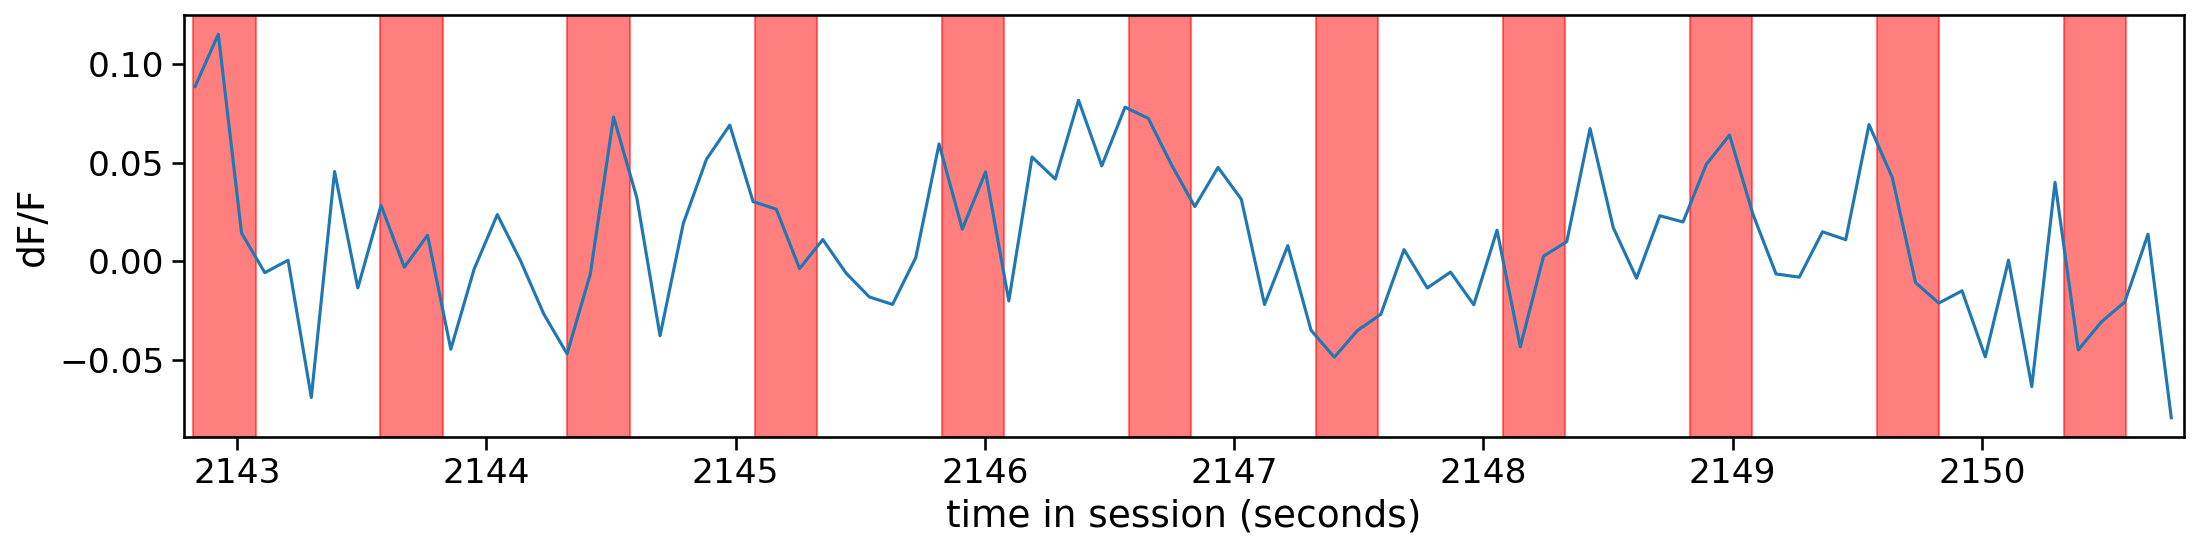

In [805]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, samp)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, trial, cell_avg=True)

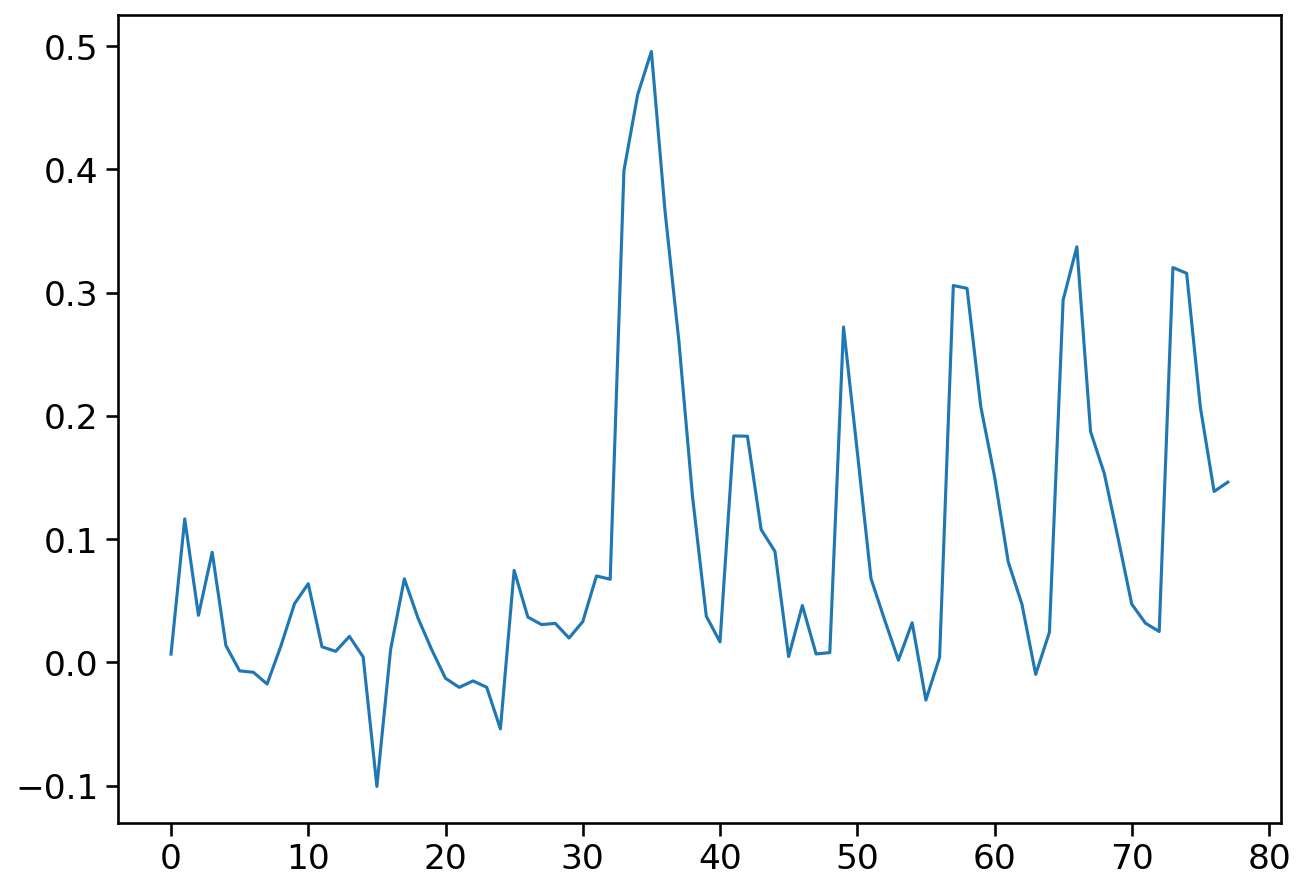

In [775]:
plt.plot(dff_avg)

In [703]:
# stim_presentations

In [704]:
# dataset.stimulus_presentations

In [683]:
trial_mask.shape

(48288,)

In [673]:
# dataset.stimulus_presentations[dataset.stimulus_presentations['omitted']==True]

In [674]:
# dataset.stimulus_presentations

In [313]:
np.unique(trial_table.change_image_name_x)

array(['im061', 'im062', 'im063', 'im065', 'im066', 'im069', 'im077',
       'im085'], dtype=object)

In [291]:
trials_nc = trial_table[trial_table.is_change_x==True]

In [715]:
samp = trials_nc.iloc[3] ## 42, 3, 24, 5, 50, 22

In [716]:
start_time = samp.start_time_x
stop_time = samp.stop_time_x
change_time = samp.change_time_x

In [717]:
sub_start = change_time - 0.5 - 0.25
sub_end = change_time + 0.25 + 0.5

In [718]:
sub_start

374.13029530548766

In [719]:
sub_end

375.63029530548766

In [723]:
len(dff)

78

In [721]:
change_time

374.88029530548766

In [722]:
stop_time - start_time

7.305960000000027

In [724]:
delta = (stop_time - start_time)/len(dff)

In [725]:
delta

0.09366615384615419

In [661]:
change_point = int((change_time - start_time)/delta)
change_point

39

In [662]:
diff = int((0.5+0.25)/delta)
start_point = change_point - diff
end_point = change_point + diff

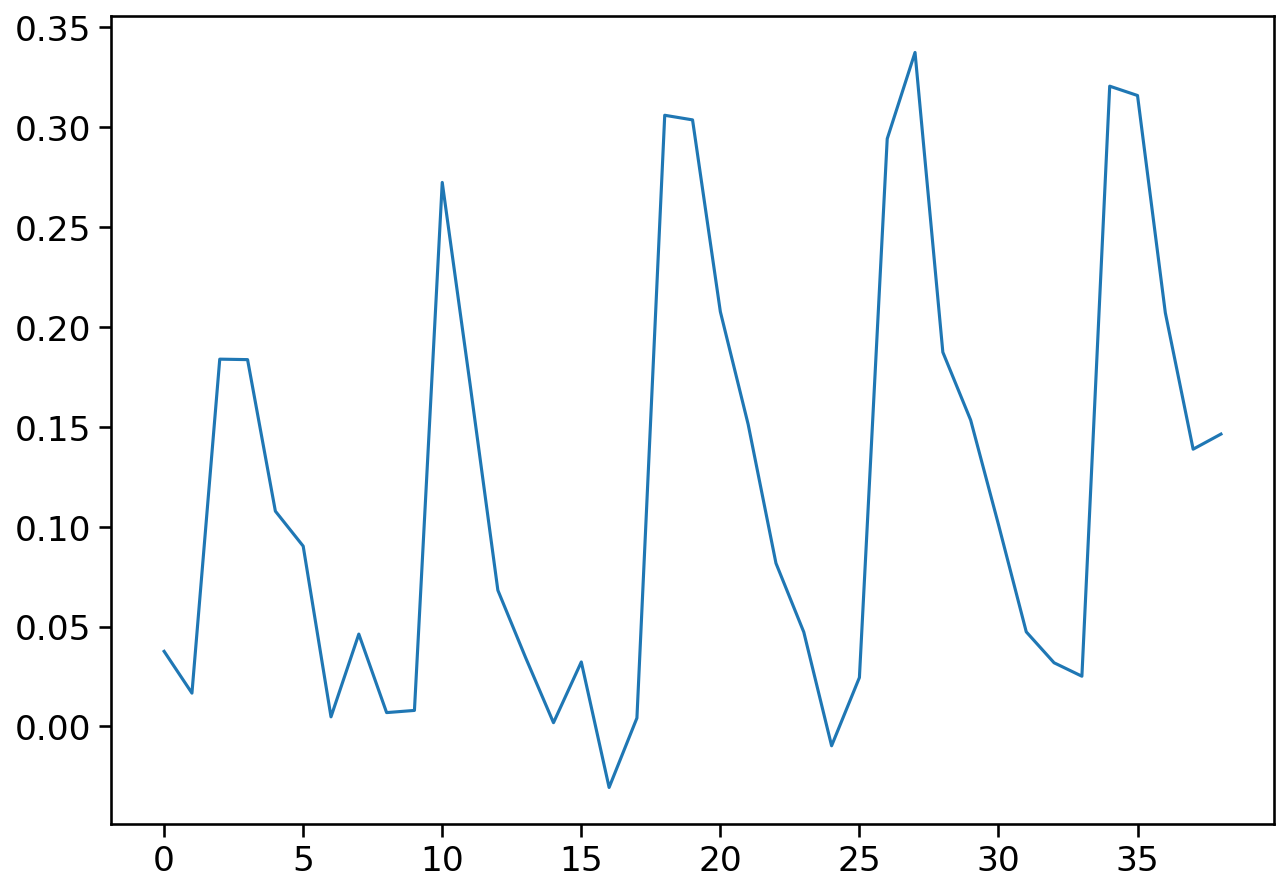

In [671]:
plt.plot(dff[change_point:])

In [663]:
end_point

48

In [664]:
start_point

30

In [665]:
end_point - start_point

18

In [666]:
# samp

In [667]:
trial_mask = (dataset.ophys_timestamps >= samp['start_time_x']) &\
            (dataset.ophys_timestamps <= samp['stop_time_x'])

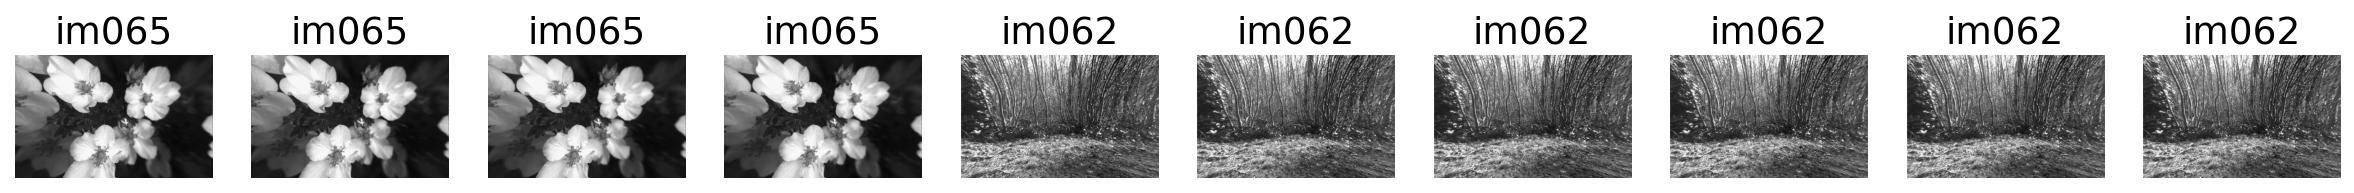

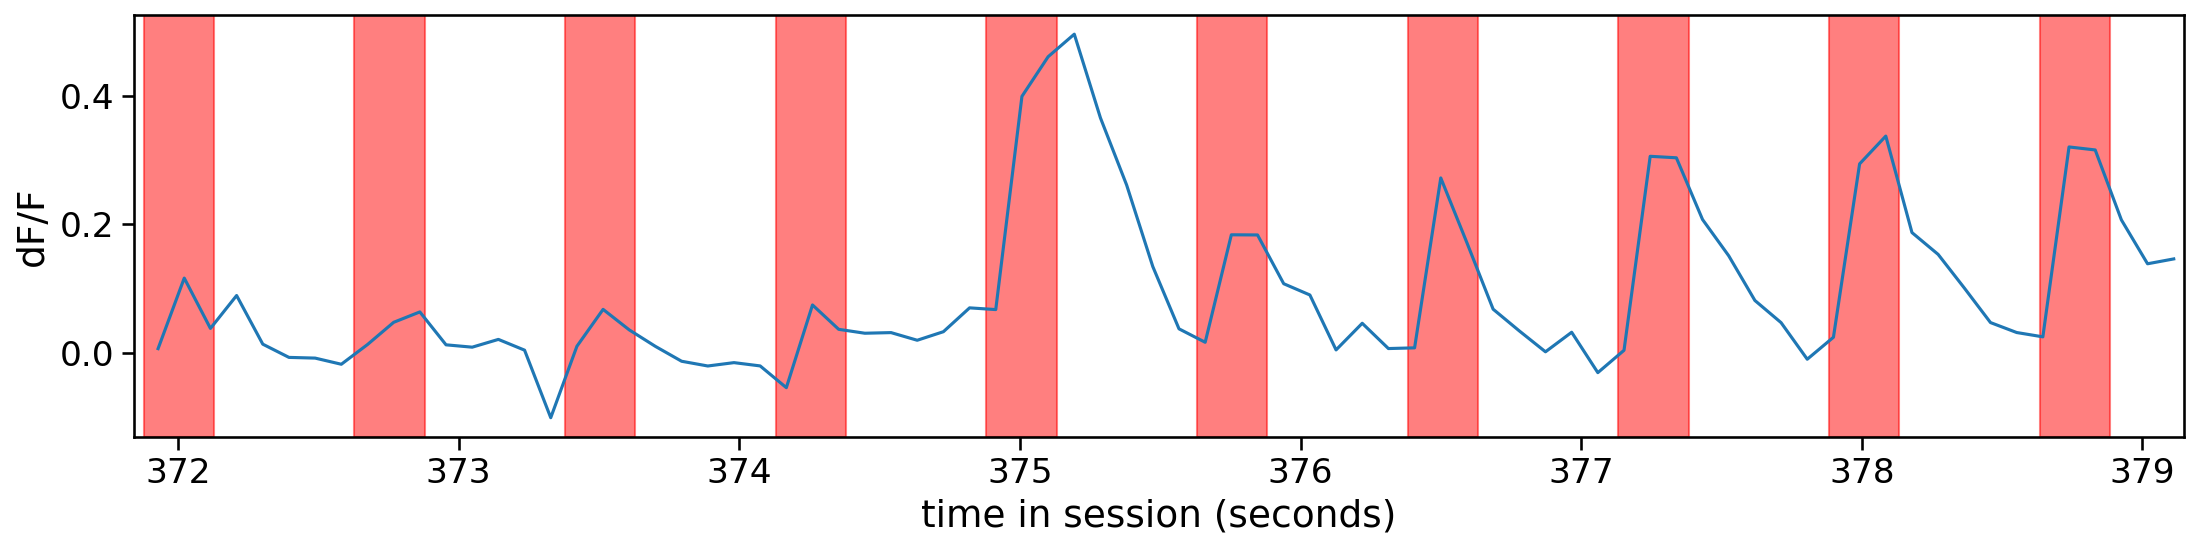

In [672]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, samp)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, samp, cell_avg=True)

0.25020000000000664

0.500409999999988

In [696]:
stim

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,stimulus_name,active
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
87,1,change_detection_behavior,0,im065,-99,0.25020,371.877845,372.128045,21856,21871,False,False,False,-99,23,23,False,Natural_Images_Lum_Matched_set_training_2017,True
88,1,change_detection_behavior,0,im065,-99,0.25018,372.628455,372.878635,21901,21916,False,False,False,-99,24,23,False,Natural_Images_Lum_Matched_set_training_2017,True
89,1,change_detection_behavior,0,im065,-99,0.25020,373.379065,373.629265,21946,21961,False,False,False,-99,25,23,False,Natural_Images_Lum_Matched_set_training_2017,True
90,1,change_detection_behavior,0,im065,-99,0.25022,374.129665,374.379885,21991,22006,False,False,False,-99,26,23,False,Natural_Images_Lum_Matched_set_training_2017,True
91,1,change_detection_behavior,5,im062,-99,0.25021,374.880295,375.130505,22036,22051,True,False,False,-99,0,23,False,Natural_Images_Lum_Matched_set_training_2017,True
92,1,change_detection_behavior,5,im062,-99,0.25015,375.630915,375.881065,22081,22096,False,False,False,-99,1,23,False,Natural_Images_Lum_Matched_set_training_2017,True
93,1,change_detection_behavior,5,im062,-99,0.25019,376.381505,376.631695,22126,22141,False,False,False,-99,2,23,False,Natural_Images_Lum_Matched_set_training_2017,True
94,1,change_detection_behavior,5,im062,-99,0.25023,377.132095,377.382325,22171,22186,False,False,False,-99,3,23,False,Natural_Images_Lum_Matched_set_training_2017,True
95,1,change_detection_behavior,5,im062,-99,0.25019,377.882715,378.132905,22216,22231,False,False,False,-99,4,23,False,Natural_Images_Lum_Matched_set_training_2017,True


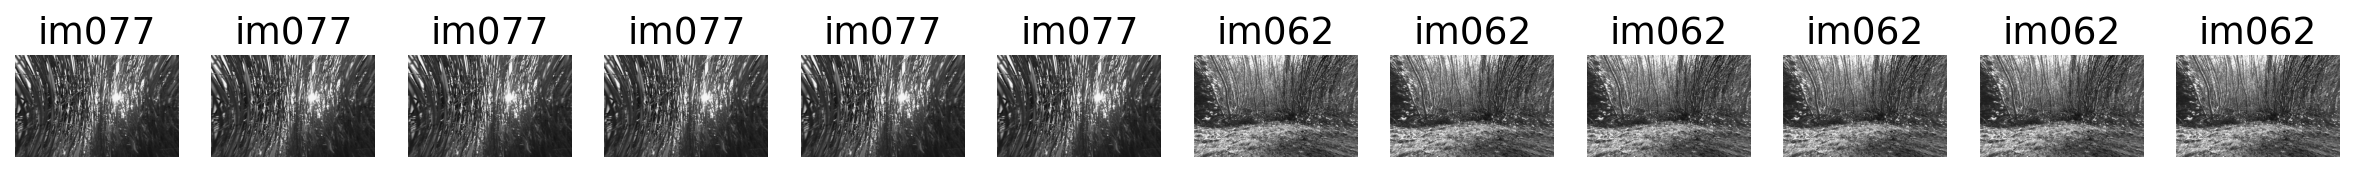

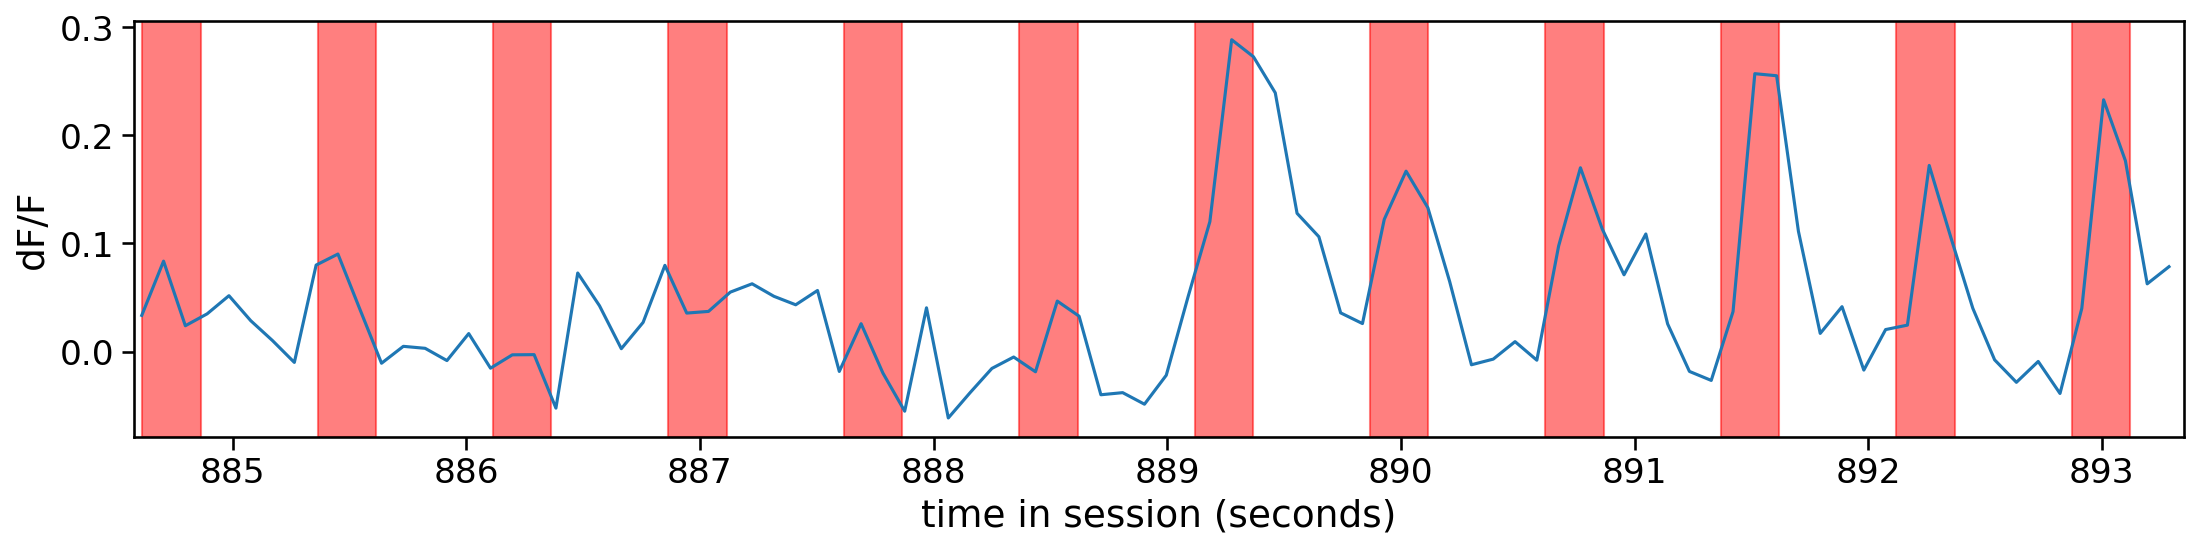

In [651]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, samp)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, samp, cell_avg=True)

In [669]:
len(dff)

78

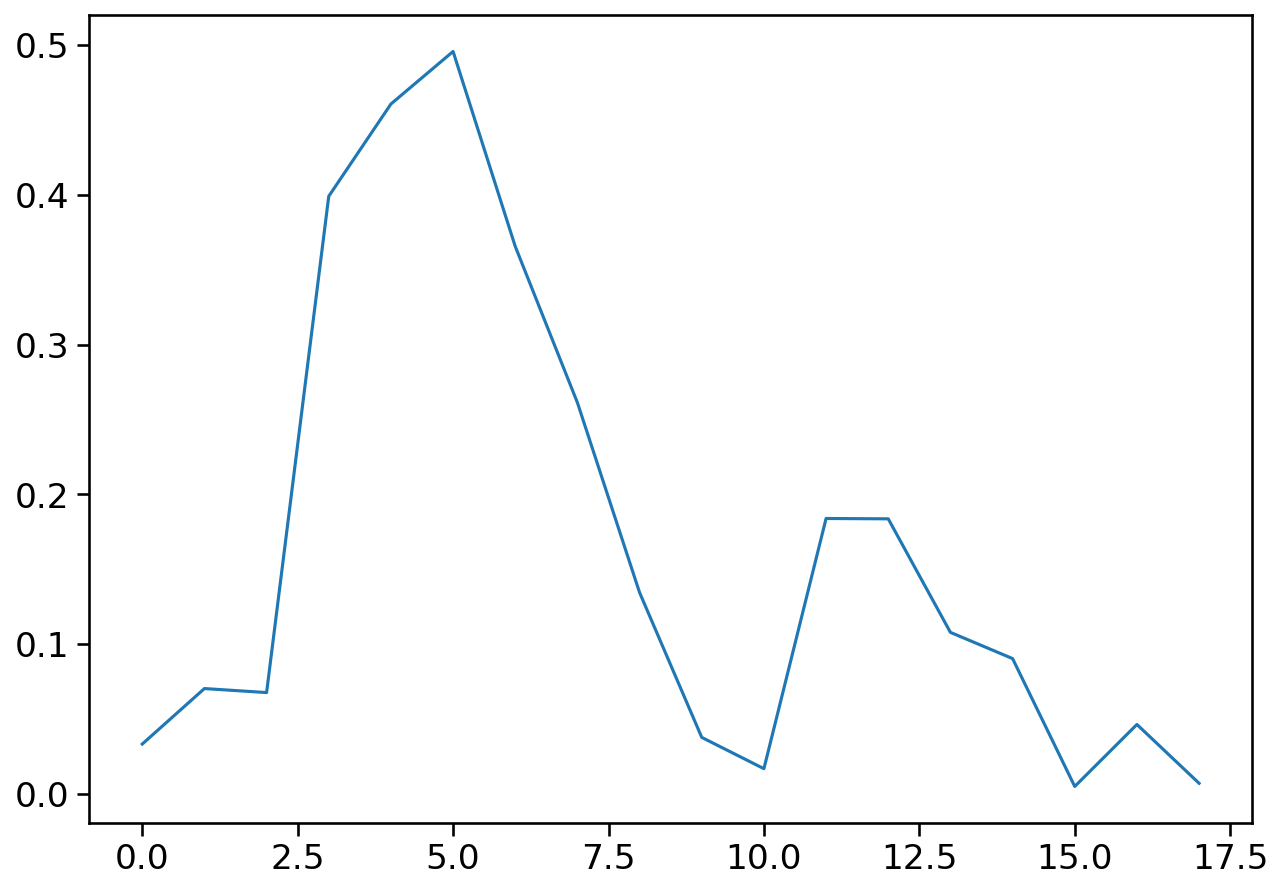

In [670]:
plt.plot(dff[start_point:end_point])

(94,)


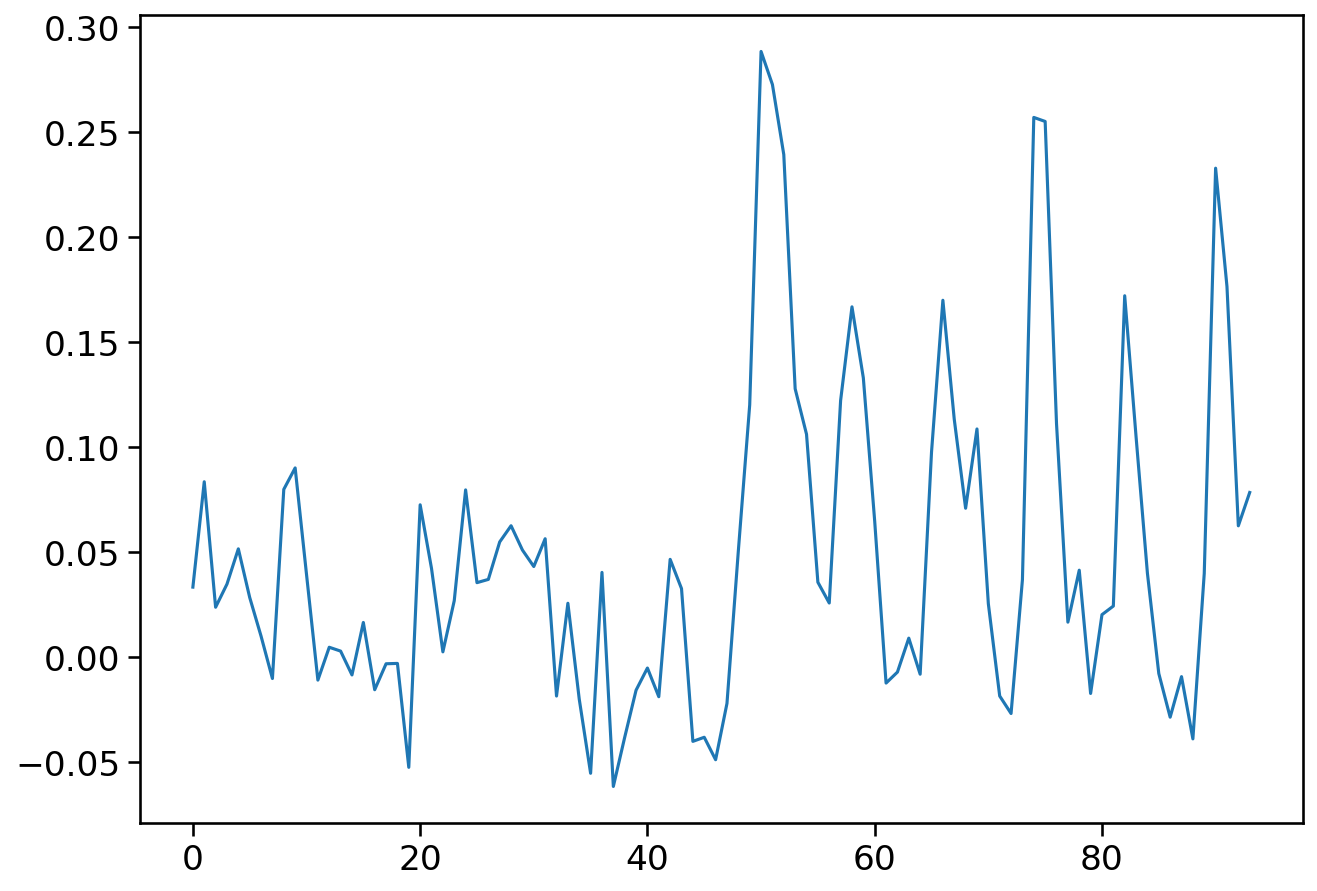

In [494]:
print(dff.shape)
plt.plot(dff)

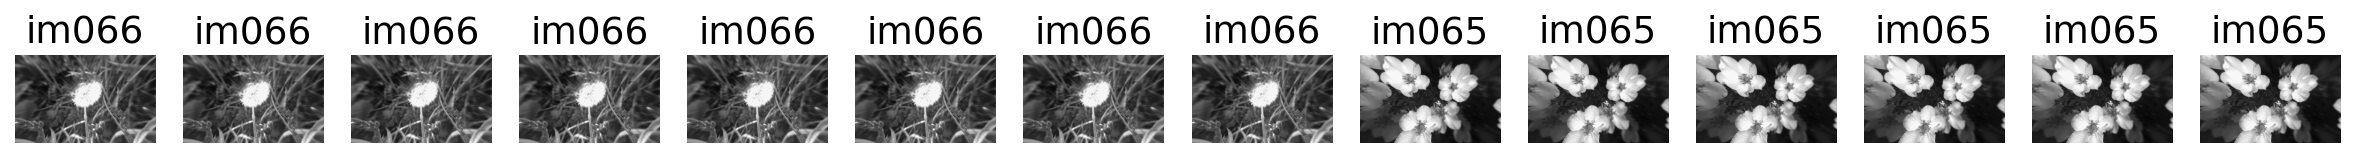

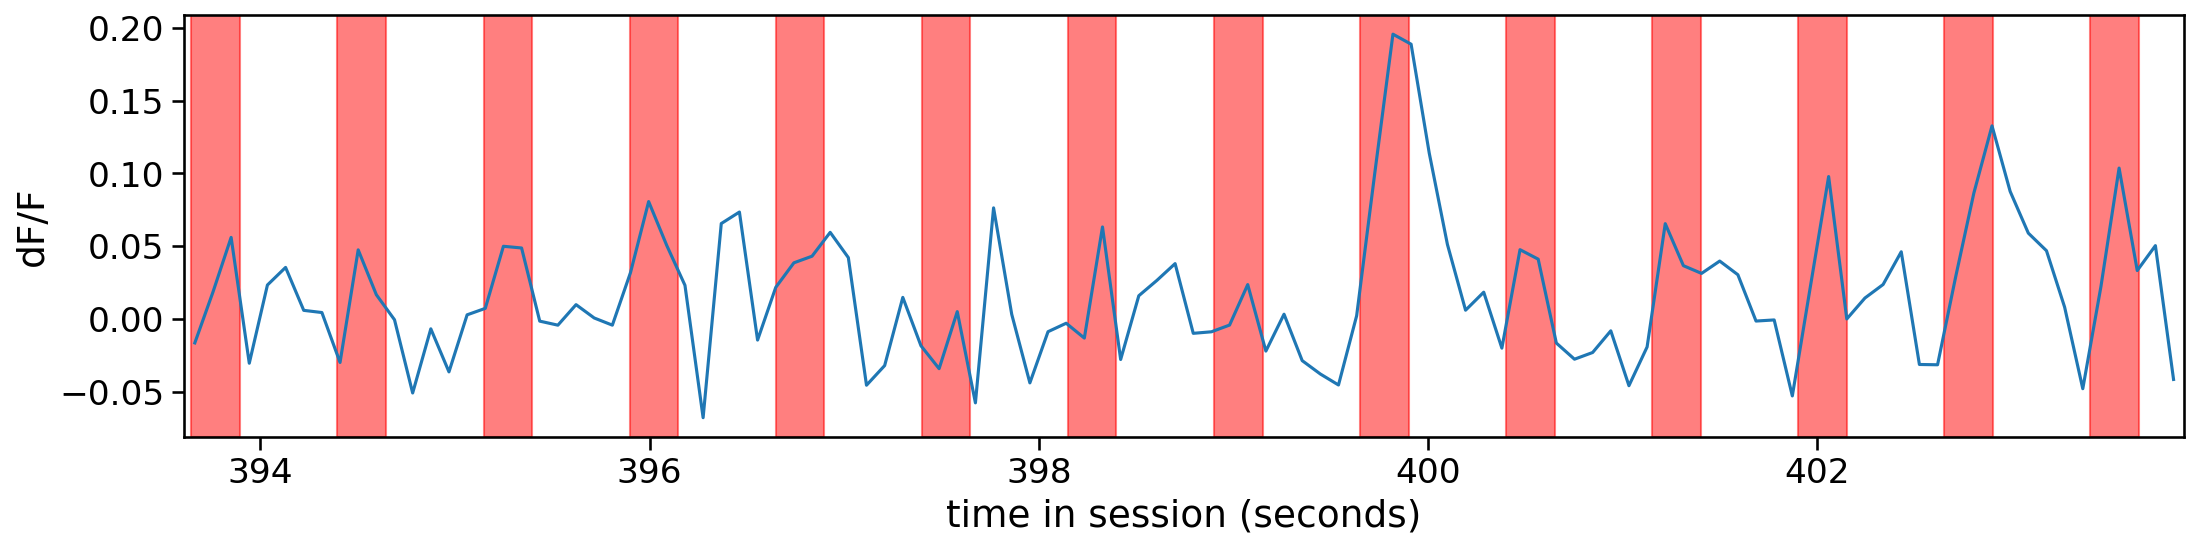

In [303]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, samp)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, samp, cell_avg=True)

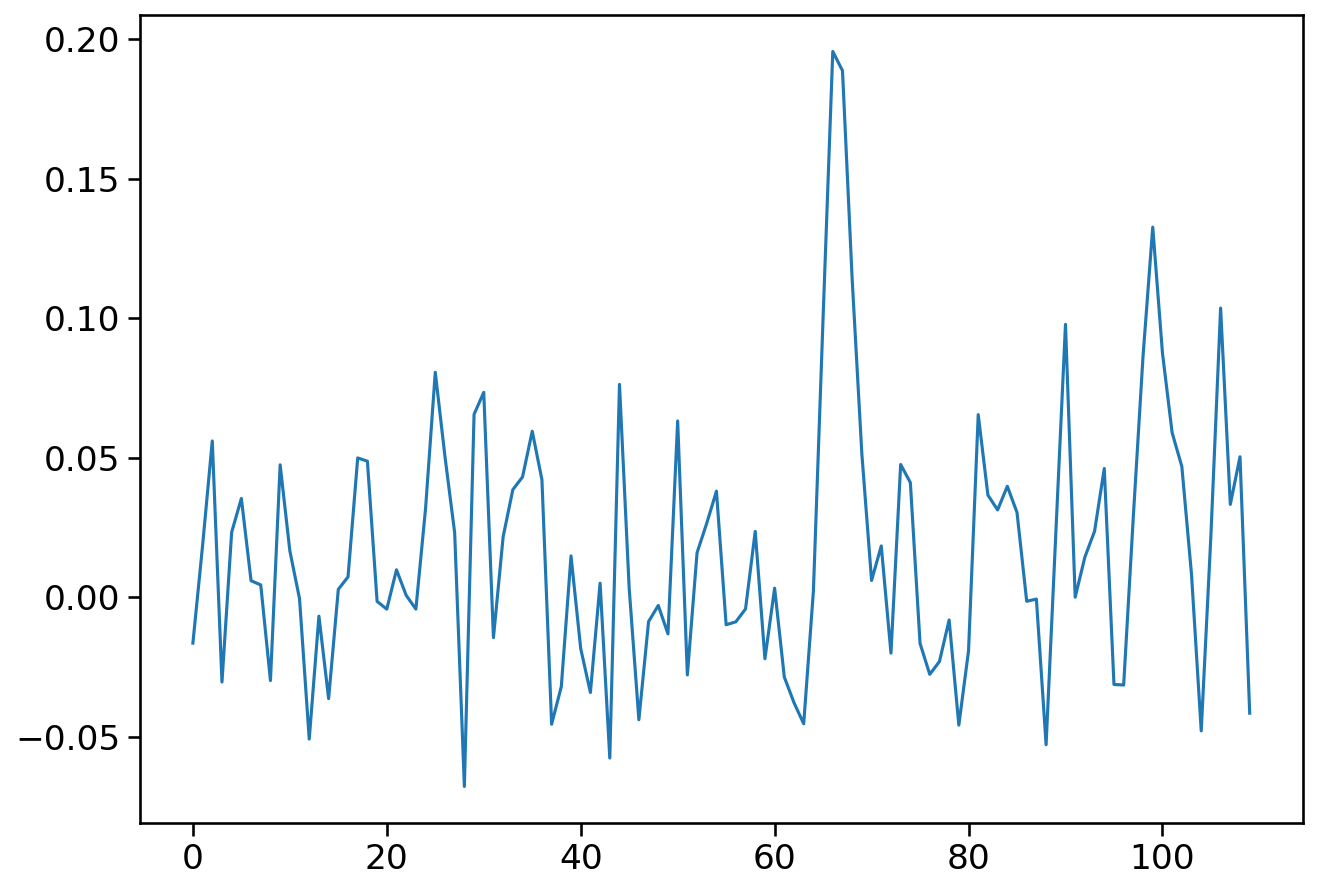

In [309]:
plt.plot(dff)

In [239]:
trials_nc.query('hit_x')

,start_time_x,stop_time_x,initial_image_name_x,change_image_name_x,is_change_x,change_time_x,go_x,catch_x,lick_times_x,response_time_x,...,reward_time_y,reward_volume_y,hit_y,false_alarm_y,miss_y,correct_reject_y,aborted_y,auto_rewarded_y,change_frame_y,trial_length_y
trials_id,,,,,,,,,,,,,,,,,,,,,


In [228]:
trial

start_time_x                                                    434.53175
stop_time_x                                                      443.3223
initial_image_name_x                                                im065
change_image_name_x                                                 im063
is_change_x                                                          True
change_time_x                                                  439.071554
go_x                                                                 True
catch_x                                                             False
lick_times_x            [439.48581, 439.60257, 439.8861, 440.01955, 44...
response_time_x                                                 439.48581
response_latency_x                                               0.414256
reward_time_x                                                   439.48581
reward_volume_x                                                     0.007
hit_x                                 

In [256]:
trial_table.iloc[0]

start_time_x                         309.91326
stop_time_x                          311.64802
initial_image_name_x                     im065
change_image_name_x                      im065
is_change_x                              False
change_time_x                              NaN
go_x                                     False
catch_x                                  False
lick_times_x            [311.14761, 311.33108]
response_time_x                            NaN
response_latency_x                         NaN
reward_time_x                              NaN
reward_volume_x                            0.0
hit_x                                    False
false_alarm_x                            False
miss_x                                   False
correct_reject_x                         False
aborted_x                                 True
auto_rewarded_x                          False
change_frame_x                             -99
trial_length_x                         1.73476
start_time_y 

In [173]:
dff_trial.shape

(86, 86)

In [174]:
dff_array.shape

(86, 48348)

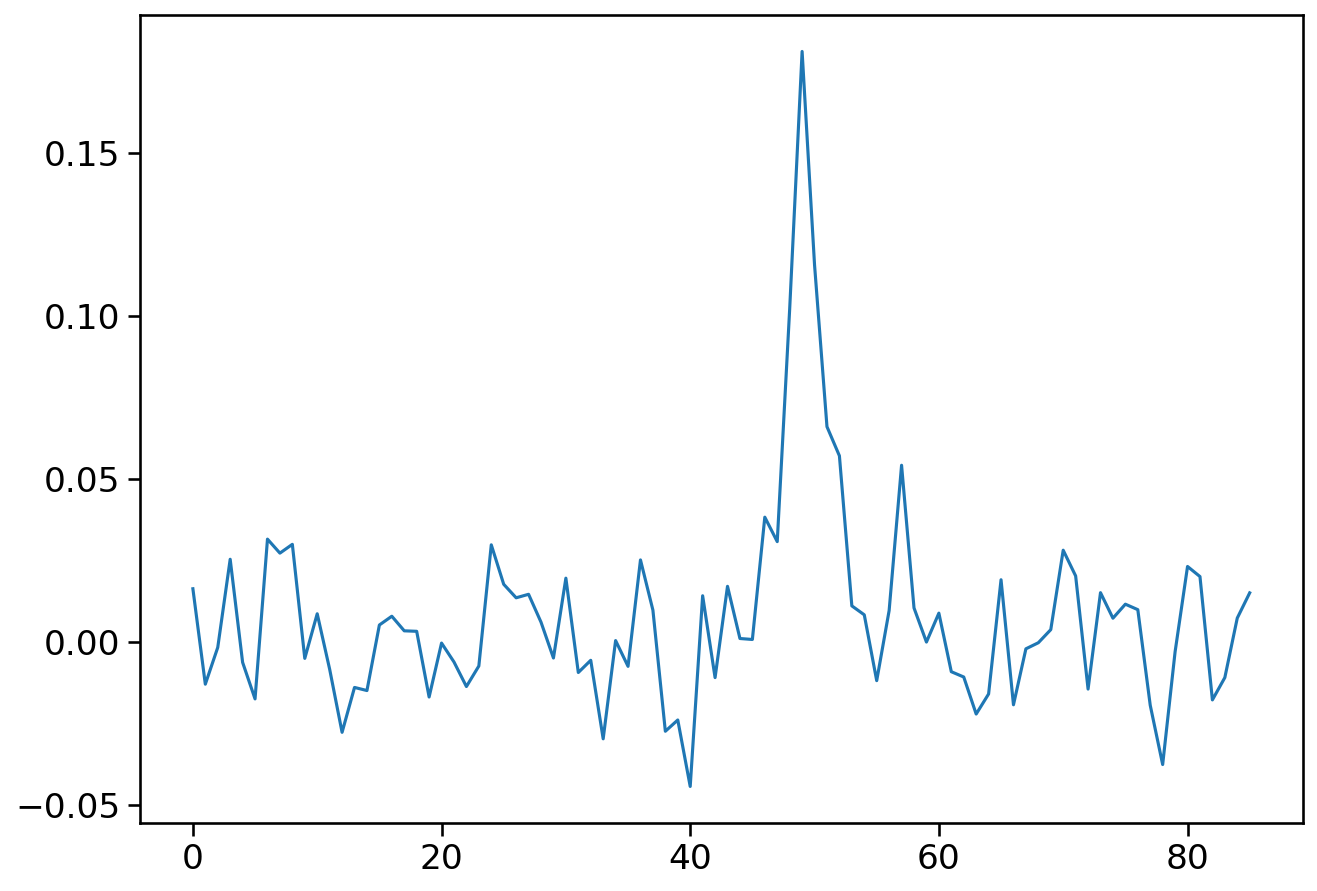

In [175]:
plt.plot(np.mean(dff_trial,0))

In [ ]:
dataset.ophys_timestamps[trial_mask], np.mean(dff_trial, 0)

In [142]:
len(pyr_visp_L23_ophys_ids)

63

In [139]:
trial_table

,start_time_x,stop_time_x,initial_image_name_x,change_image_name_x,is_change_x,change_time_x,go_x,catch_x,lick_times_x,response_time_x,...,reward_time_y,reward_volume_y,hit_y,false_alarm_y,miss_y,correct_reject_y,aborted_y,auto_rewarded_y,change_frame_y,trial_length_y
trials_id,,,,,,,,,,,,,,,,,,,,,
0,309.91326,311.64802,im065,im065,False,NaN,False,False,"[311.14761, 311.33108]",NaN,...,NaN,0.000,False,False,False,False,True,False,-99,1.73476
1,312.16510,319.45439,im065,im085,True,315.203624,False,False,"[315.23428, 315.60123, 315.80138, 315.93485, 3...",315.23428,...,315.33436,0.005,False,False,False,False,False,True,18300,7.28929
2,319.67122,320.05488,im085,im085,False,NaN,False,False,[319.75464],NaN,...,315.33436,0.000,False,False,False,False,True,False,-99,0.38366
3,320.42182,321.28923,im085,im085,False,NaN,False,False,"[320.47186, 320.70545, 320.98898, 321.30591, 3...",NaN,...,315.33436,0.000,False,False,False,False,True,False,-99,0.86741
4,321.92308,322.65698,im085,im085,False,NaN,False,False,"[322.08988, 322.34009]",NaN,...,315.33436,0.000,False,False,False,False,True,False,-99,0.73390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,3876.59360,3883.86621,im061,im077,True,3879.632114,True,False,[],NaN,...,2930.48744,0.000,False,False,True,False,False,False,231991,7.27261
626,3884.09971,3893.64084,im077,im065,True,3889.390094,True,False,[],NaN,...,2930.48744,0.000,False,False,True,False,False,False,232576,9.54113
627,3893.85767,3901.88092,im065,im062,True,3897.646834,True,False,[],NaN,...,2930.48744,0.000,False,False,True,False,False,False,233071,8.02325


In [132]:
# pc_sample_exp.cell_specimen_table
dataset.stimulus_presentations

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,stimulus_name,active
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,309.949324,0.000000,309.949324,0,17985,False,<NA>,<NA>,-99,0,-99,False,spontaneous,False
1,1,change_detection_behavior,0,im065,-99,0.250210,309.949324,310.199534,17985,18000,False,False,False,-99,1,0,False,Natural_Images_Lum_Matched_set_training_2017,True
2,1,change_detection_behavior,0,im065,-99,0.250200,310.699944,310.950144,18030,18045,False,False,False,-99,2,0,False,Natural_Images_Lum_Matched_set_training_2017,True
3,1,change_detection_behavior,0,im065,-99,0.250230,311.450554,311.700784,18075,18090,False,False,False,-99,3,0,False,Natural_Images_Lum_Matched_set_training_2017,True
4,1,change_detection_behavior,0,im065,-99,0.250180,312.201164,312.451344,18120,18135,False,False,False,-99,4,1,False,Natural_Images_Lum_Matched_set_training_2017,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13802,3,natural_movie_one,-99,NaN,895,0.033350,4517.269614,4517.302964,270218,270219,False,<NA>,<NA>,9,9001,-99,False,natural_movie_one,False
13803,3,natural_movie_one,-99,NaN,896,0.033370,4517.302964,4517.336334,270220,270221,False,<NA>,<NA>,9,9002,-99,False,natural_movie_one,False
13804,3,natural_movie_one,-99,NaN,897,0.033380,4517.336334,4517.369714,270222,270223,False,<NA>,<NA>,9,9003,-99,False,natural_movie_one,False


In [123]:
dataset = pyr_exp_V1_L23 
filtered_stimuli = dataset.stimulus_presentations[(dataset.stimulus_presentations['start_time'] >= 1500) &
        (dataset.stimulus_presentations['start_time'] <= 2000)]
images = [image_name for image_name in filtered_stimuli['image_name']]
# filtered_stimuli = dataset.stimulus_presentations[(dataset.stimulus_presentations['start_time'] >= start_time) &
#         (dataset.stimulus_presentations['start_time'] <= stop_time)]

In [274]:
default_color = (0.5, 0.5, 0.5)  # Use gray as a default color, adjust as needed

In [272]:
def plot_images_with_time(start_time, stop_time, dataset, trial):
    '''
    Plot images with time.

    Parameters:
    - start_time: Start time of the trial.
    - stop_time: Stop time of the trial.
    - dataset: Dataset containing stimulus presentations.
    - trial: Trial information.

    Returns:
    - fig: Figure object.
    - axs: AxesSubplot objects.
    '''
    # Filter stimulus presentations based on start and stop times
    filtered_stimuli = dataset.stimulus_presentations[
        (dataset.stimulus_presentations['start_time'] >= start_time) &
        (dataset.stimulus_presentations['start_time'] <= stop_time)
    ]

    # Extract image names using a list comprehension
    images = [image_name for image_name in filtered_stimuli['image_name']]

    # Visualize images
    fig, axs = plt.subplots(1, len(images), squeeze=False)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        image_name = images[i]
        # Check if the image_name is 'omitted', if so, display a blank image
        if image_name == 'omitted':
            # Create a blank image (assuming the size is 63x100 pixels and gray)
            blank_image = np.ones((63, 100), dtype=np.uint8) * 255  # Create a white image
            ax.imshow(blank_image, cmap='gray')
            ax.set_title('Omitted')
        else:
            # Display the actual image
            ax.imshow(dataset.stimulus_templates['warped'].get(image_name, default_color), cmap='gray')
            ax.set_title(image_name)

        ax.axis('off')

    fig.set_size_inches(20, 20)

    return fig, axs

In [270]:
def plot_stimuli(dataset, trial, ax):
    '''
    Plot stimuli as colored bars on specified axis.
    
    Parameters:
    - dataset: Dataset containing stimulus information.
    - trial: Trial for which stimuli are plotted.
    - ax: Axis object to plot stimuli on.
    '''
    # Extract start_time and stop_time from the trial
    start_time = float(trial['start_time_x'])
    stop_time = float(trial['stop_time_x'])

    # Create a boolean mask for rows within the specified time range
    mask = (dataset.stimulus_presentations['end_time'] >= start_time) & \
           (dataset.stimulus_presentations['start_time'] <= stop_time) & \
           (~dataset.stimulus_presentations['omitted'])

    # Use the boolean mask to filter the DataFrame
    stimuli = dataset.stimulus_presentations[mask]
    
    # Plot colored bars for each stimulus presentation
    for idx, stimulus in stimuli.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color='red', alpha=0.5)
        
    return stimuli

def plot_dff(dataset, trial, ax, cell_avg=False):
    '''
    Plot each cell's dff response for a given trial.
    
    Parameters:
    - dataset: Dataset containing dF/F traces.
    - trial: Trial for which dF/F responses are plotted.
    - ax: Axis object to plot dF/F responses on.
    - cell_avg: Whether to plot average dF/F across cells (default is False).
    '''
    # Extract dF/F traces from the dataset
    dff_array = np.vstack(dataset.dff_traces['dff'].values)
    
    # Create a boolean mask for timestamps within the trial's time range
    trial_mask = (dataset.ophys_timestamps >= trial['start_time_x']) & \
                 (dataset.ophys_timestamps <= trial['stop_time_x'])
    
    # Filter dF/F traces based on the trial mask
    dff_trial = dff_array[:, trial_mask]
    
    # Plot dF/F responses
    if cell_avg:
        ax.plot(dataset.ophys_timestamps[trial_mask], np.mean(dff_trial, 0))
    else:
        ax.plot(dataset.ophys_timestamps[trial_mask], dff_trial.T)
        ax.set_title('deltaF/F responses')
        ax.set_ylabel('dF/F')
    
    return np.mean(dff_trial, 0), trial_mask

def make_trial_plot(dataset, trial, cell_avg=False):
    '''
    Combine all plots for a given trial.
    
    Parameters:
    - dataset: Dataset to plot.
    - trial: Trial for the dataset.
    - cell_avg: Whether to plot average dF/F across cells (default is False).
    '''
    # Create a time array from start_time to stop_time
    start_time = float(trial['start_time_x'])
    stop_time = float(trial['stop_time_x'])
    time_array = np.linspace(start_time, stop_time, num=1000)  # You can adjust the number of points (num) as needed

    # Create a figure and axis object for plotting
    fig, ax = plt.subplots(figsize=(15, 4))  # Adjust the height as needed

    # Plot stimuli
    stim = plot_stimuli(dataset, trial, ax)

    # Plot dF/F
    dff, trial_mask = plot_dff(dataset, trial, ax, cell_avg=cell_avg)

    # Set x-axis limits and labels
    ax.set_xlim(start_time, stop_time)
    ax.set_xlabel('time in session (seconds)')
    ax.set_ylabel('dF/F')

    # Adjust layout to prevent overlap
    fig.tight_layout()

    plt.show()
    return stim, dff, trial_mask

In [ ]:
# pc trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(pc_sample_trial.start_time_x, pc_sample_trial.stop_time_x, pc_sample_exp, pc_sample_trial)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(pc_sample_exp, pc_sample_trial, cell_avg=True)

In [125]:
len(images)

666

In [127]:
dataset.stimulus_presentations

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,stimulus_name,active
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,309.949324,0.000000,309.949324,0,17985,False,<NA>,<NA>,-99,0,-99,False,spontaneous,False
1,1,change_detection_behavior,0,im065,-99,0.250210,309.949324,310.199534,17985,18000,False,False,False,-99,1,0,False,Natural_Images_Lum_Matched_set_training_2017,True
2,1,change_detection_behavior,0,im065,-99,0.250200,310.699944,310.950144,18030,18045,False,False,False,-99,2,0,False,Natural_Images_Lum_Matched_set_training_2017,True
3,1,change_detection_behavior,0,im065,-99,0.250230,311.450554,311.700784,18075,18090,False,False,False,-99,3,0,False,Natural_Images_Lum_Matched_set_training_2017,True
4,1,change_detection_behavior,0,im065,-99,0.250180,312.201164,312.451344,18120,18135,False,False,False,-99,4,1,False,Natural_Images_Lum_Matched_set_training_2017,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13802,3,natural_movie_one,-99,NaN,895,0.033350,4517.269614,4517.302964,270218,270219,False,<NA>,<NA>,9,9001,-99,False,natural_movie_one,False
13803,3,natural_movie_one,-99,NaN,896,0.033370,4517.302964,4517.336334,270220,270221,False,<NA>,<NA>,9,9002,-99,False,natural_movie_one,False
13804,3,natural_movie_one,-99,NaN,897,0.033380,4517.336334,4517.369714,270222,270223,False,<NA>,<NA>,9,9003,-99,False,natural_movie_one,False


In [122]:
pyr_exp_V1_L23 = bc.get_behavior_ophys_experiment(pyr_visp_L23_ophys_ids.index[0])

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [121]:
filter_pyr.index

Int64Index([ 986518876,  986518878,  986518880,  986518885,  986518887,
             986518889,  986518891,  986518893,  989213058,  989213059,
            ...
            1084816956, 1084816958, 1084816959, 1084816961, 1084816962,
            1084816952, 1085840413, 1085840416, 1085840417, 1085840420],
           dtype='int64', name='ophys_experiment_id', length=238)

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [115]:
len(filter_pyr.index)

238

Int64Index([ 877696762,  879332693,  880375092,  881881171,  882935355,
             884218326,  992870935,  993344852,  993594789,  993863108,
            ...
            1048044018, 1049332782, 1050725735, 1050730732, 1051011761,
            1051216600,  775614751,  778644591,  788490510,  796106850],
           dtype='int64', name='ophys_experiment_id', length=871)

In [9]:
# ## Specific experiments

# ## Length of recordings vary, but roughly in the 40k range

# ## V1
# pyr_exp_V1_L23 = bc.get_behavior_ophys_experiment(pc_exp_table.index[1]) ## new
# sst_exp_V1_L23 = bc.get_behavior_ophys_experiment(sst_exp_table.index[0]) ## new
# vip_exp_V1_L23 = bc.get_behavior_ophys_experiment(vip_exp_table.index[0]) ## new

# pyr_exp_V1_L4 = bc.get_behavior_ophys_experiment(pc_exp_table.index[36]) ## new
# sst_exp_V1_L4 = bc.get_behavior_ophys_experiment(sst_exp_table.index[0]) ## new
# vip_exp_V1_L4 = bc.get_behavior_ophys_experiment(vip_exp_table.index[86]) ## new

# pyr_exp_V1_L5 = bc.get_behavior_ophys_experiment(pc_exp_table.index[36]) ## new
# sst_exp_V1_L5 = bc.get_behavior_ophys_experiment(sst_exp_table.index[120]) ## new
# vip_exp_V1_L5 = bc.get_behavior_ophys_experiment(vip_exp_table.index[417]) ## new

# ## LM
# pyr_exp_LM_L23 = bc.get_behavior_ophys_experiment(pc_exp_table.index[52]) ## new 
# sst_exp_LM_L23 = bc.get_behavior_ophys_experiment(sst_exp_table.index[0]) ## new
# vip_exp_LM_L23 = bc.get_behavior_ophys_experiment(vip_exp_table.index[42]) ## new

# pyr_exp_LM_L4 = bc.get_behavior_ophys_experiment(pc_exp_table.index[36]) ## new
# sst_exp_LM_L4 = bc.get_behavior_ophys_experiment(sst_exp_table.index[0]) ## new
# vip_exp_LM_L4 = bc.get_behavior_ophys_experiment(vip_exp_table.index[86]) ## new

# pyr_exp_LM_L5 = bc.get_behavior_ophys_experiment(pc_exp_table.index[36]) ## new
# sst_exp_LM_L5 = bc.get_behavior_ophys_experiment(sst_exp_table.index[120]) ## new
# vip_exp_LM_L5 = bc.get_behavior_ophys_experiment(vip_exp_table.index[199]) ## new

behavior_ophys_experiment_879332693.nwb: 100%|█| 2.22G/2.22G [01:19<00:00, 27.7M
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980471.nwb: 100%|█| 248M/248M [00:09<00:00, 25.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_792815735.nwb: 100%|█| 360M/360M [00:12<00:00, 27.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518876.nwb: 100%|█| 382M/382M [00:13<00:00, 28.9MMB
/home/abalwani6/.local/lib/python3.10/site-pac